Analyse exploratoire :

    Etude de la dépendance des variables quantitatives aux variables qualitatives : test ANOVA.
        Variables quantitatives, dépendantes : indice de toxicité.
        Variables qualitatives indépendantes : sous-catégories de toxicité.
    
    Etude de la correlation des variables qualitatives entre elles : test du Xi-2.

Ces premiers résultats montrent une limite dans les performances du modèle.
Cette limite a problablement deux sources: 

1) les hypothèses sous-jacentes qui ont été formulées 
et conduisant à un biais.
Parmi ces hypothèses : 
    * BOW : absence de lien sémantique du fait de l'absence d'ordre dans les mots lors de la construction 
    des variables explicatives.
    
    * Features : l'ensemble des features n'est pas suffisante pour que le modele 
    performe au dela des limites actuelles. En d'autres termes, l'ensemble des 
    variables explicatives n'est pas suffisant pour extraire l'information des 
    données de façon à rendre le modele plus performant.

2) Le  déséquilibre entre les distributions des commentaires etiquettés avec un 
score de toxicité positif et les distributions avec le score de toxicité à zéro.
    
    Ce déséquilibre entre implique que les textes avec un indice de toxicité >0.0 vont peu
    contribuer a la diminution de la fonction de coût. Ce qui explique le comportement des courbes 
    de fonctions de coût pour les données d'entraînement et les données de test.

Pour aborder le pb du biais, une approche consiste à enrichir le modele avec les 
informations qualitatives des sous-catégories définissant la toxicité.
Pour ce faire, les expressions et mots ne faisant pas partie du vocabulaire du language natuel vont être intégrés au modèle de données, en plus du vocabulaire naturel issue du langage.

L'analyse des mots en dehors du vocabulaire naturel est explorée afin de trouver des relations entre 
le score de toxicité et les-dits mots.

Pour le déséquilibre des distributions, une approche consiste à :

    * traiter séparément les commentaires toxiques et non toxiques (ces derniers ayant un score à zéro).
    * rééquilibrer les classes en enlevant des textes non toxiques. Plusieurs dataset de test sont ainsi consitués pour entraîner le modèle, à l'image d'une cross-validation.

L'approche TF-IDF est substituée au BOW dans le cadre de l'extraction de features. Cette disposition vise à enrichir le niveau extractible d'information du modèle de données information. Les valeurs du grammage pour la configuration de l'algorithme TF-IDF peuvent être testés de 1 à 5.


L'approche Words Embeddings, qui elle, tient compte de l'ordre des mots dans le texte et définie ainsi un cadre sémantique pour chacun des mots va constituer une dernière approche pour enrichir la complexité du modele en vue de le rendre plus performant. La performance s'entend ici tant dans la phase d'entraînement que dans la phase de généralisation.

Une autre approche consiste a considérer les commentaires toxiques commme des 
anomalies et à détecter ces derniers et à les scorer.

3) Amelioration du processus de tokenization

    scaPy est réputé donner de meilleurs résultats que le tokenizer de la librairie scikit learn.
    
    Le tokenizer de la librairie gensim a aussi été utilisé.
    
4) Mécanismes d'attention
    
    Cette approche permet de traiter des corpus avec de textes de taille variables.
    
    
    

In [1]:
import jyquickhelper
jyquickhelper.add_notebook_menu(first_level=1, last_level=3, header="Dataset preparation with DatasetPreparator")

# <font color=blus>0. Notebook configuration</font>

In [4]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [5]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
import gensim
from gensim import corpora

import pandas as pd
import numpy as np


from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.base import get_data_home
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dropout

import os

import p9_util

# Full dataset
#extension='_full'

# Partial dataset
extension='_part'

Using TensorFlow backend.
W0819 20:16:53.467302 139816935085888 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0819 20:16:53.468071 139816935085888 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0819 20:16:53.478214 139816935085888 deprecation_wrapper.py:119] From /home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p8_util_config.py:137: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



# <font color=blus>1. Load datasets</font>

    Processing data is intended in splitting train dataset into new train and test dataset.
    This is done in order to train a model that we expect to generalize over provided test dataset.
    
    Provided test dataset is a file holding a collection of documents. Predictions, in term of probability 
    of toxicity, will be applied on this test dataset thanks to the estimator trained with train dataset.
    
    

In [2]:
import pandas as pd

df_test = pd.read_csv('./data/test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

df_train['comment_text'] = df_train['comment_text'].apply(lambda x : x.lower())

In [3]:
print(len(df_train))

1804874


In [9]:
for col in list(df_train.columns) :
    print(col)


id
target
comment_text
severe_toxicity
obscene
identity_attack
insult
threat
asian
atheist
bisexual
black
buddhist
christian
female
heterosexual
hindu
homosexual_gay_or_lesbian
intellectual_or_learning_disability
jewish
latino
male
muslim
other_disability
other_gender
other_race_or_ethnicity
other_religion
other_sexual_orientation
physical_disability
psychiatric_or_mental_illness
transgender
white
created_date
publication_id
parent_id
article_id
rating
funny
wow
sad
likes
disagree
sexual_explicit
identity_annotator_count
toxicity_annotator_count


## <font color=blus>1.1. Target analysis</font>

    Some text samples are displayed here under.

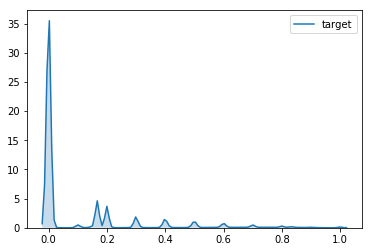

In [12]:
import seaborn as sns

y_target = df_train['target']
_ = sns.kdeplot(y_target, shade=True)


Number of texts with toxicity > 0.2 : 270194


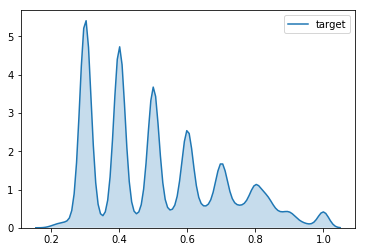

In [21]:
toxicity = 0.2
arr_index = np.where(y_target>toxicity)[0]
y_target_part = y_target[arr_index]
_ = sns.kdeplot(y_target_part, shade=True)
print("\nNumber of texts with toxicity > {} : {}".format(toxicity, len(y_target_part)))
#y_target_part.min()


Number of texts with toxicity > 0.8 : 23802


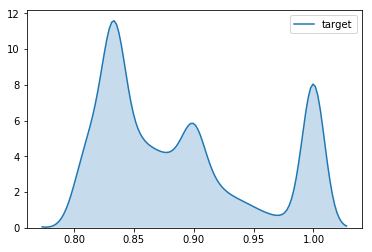

In [22]:
toxicity = 0.8
arr_index = np.where(y_target>toxicity)[0]
y_target_part = y_target[arr_index]
_ = sns.kdeplot(y_target_part, shade=True)
print("\nNumber of texts with toxicity > {} : {}".format(toxicity, len(y_target_part)))
#y_target_part.min()

## <font color=blus>1.2. Texts analysis</font>

    Texts are recorded in column named comment_text.
    
    Words freqency is displayed for the most 50 popular words.
    
    CountVectorizer is applied without any corpus normalization. This will lead to a vocabulary 
    mapping all existing words into corpus.

In [10]:
corpus = df_train[['target','comment_text']]#[:1000]
print("\nCorpus texts= {}".format(len(corpus)))
print(corpus[:10])


Corpus texts= 1804874
     target                                       comment_text
0  0.000000  this is so cool. it's like, 'would you want yo...
1  0.000000  thank you!! this would make my life a lot less...
2  0.000000  this is such an urgent design problem; kudos t...
3  0.000000  is this something i'll be able to install on m...
4  0.893617               haha you guys are a bunch of losers.
5  0.666667                               ur a sh*tty comment.
6  0.457627                        hahahahahahahahhha suck it.
7  0.000000                                ffffuuuuuuuuuuuuuuu
8  0.000000  the ranchers seem motivated by mostly by greed...
9  0.000000  it was a great show. not a combo i'd of expect...


In [7]:
print(corpus['comment_text'].iloc[7])

ffffuuuuuuuuuuuuuuu


### <font color=blus>1.2.1 Texts analysis with words frequencies</font>

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized_corpus = vectorizer.fit_transform(corpus)

#### Save / reload vectorized corpus as well as vectorizer

    Change flag True / False depending on operation to proceed.

In [40]:
import p5_util

filename = './data/vectorized_corpus.dump'
filename_vectorizer = './data/vectorizer.dump'
if False : 
    p5_util.object_dump(vectorized_corpus,filename)
    p5_util.object_dump(vectorizer,filename_vectorizer)
else : 
    vectorized_corpus = p5_util.object_load(filename)
    vectorizer = p5_util.object_load(filename_vectorizer)

p5_util.object_load : fileName= ./data/vectorized_corpus.dump
p5_util.object_load : fileName= ./data/vectorizer.dump


    Get a sample from corpus and compute a dataframe with 2 columns : word column and counting column.
    That last column handles the count of word. 
    Raws from dataset are sorted by counting column.

In [57]:
import p9_util
df_wordCounting = p9_util.get_df_wordCounting_from_vectorizer(vectorized_corpus, vectorizer)

    Free dataframe from stop words; all rows from dataframe contaning a stop word are removed.

In [61]:
import p9_util
df_wordCounting = p9_util.df_wordCounting_free_stopword(df_wordCounting)


Shape of incoming dataframe= (318304, 2)
Shape of outgoing dataframe= (317970, 2)


    Display words considering their frequency

    vectorizer.vocabulary_ attribute is a dictionary where keys are words from vocabulary and values 
    are words occurencies.
    
    This dictionay is converted as a dataframe in order to sort and plot words occurencies.
    This dataframe will contain 2 columns : word and counting.

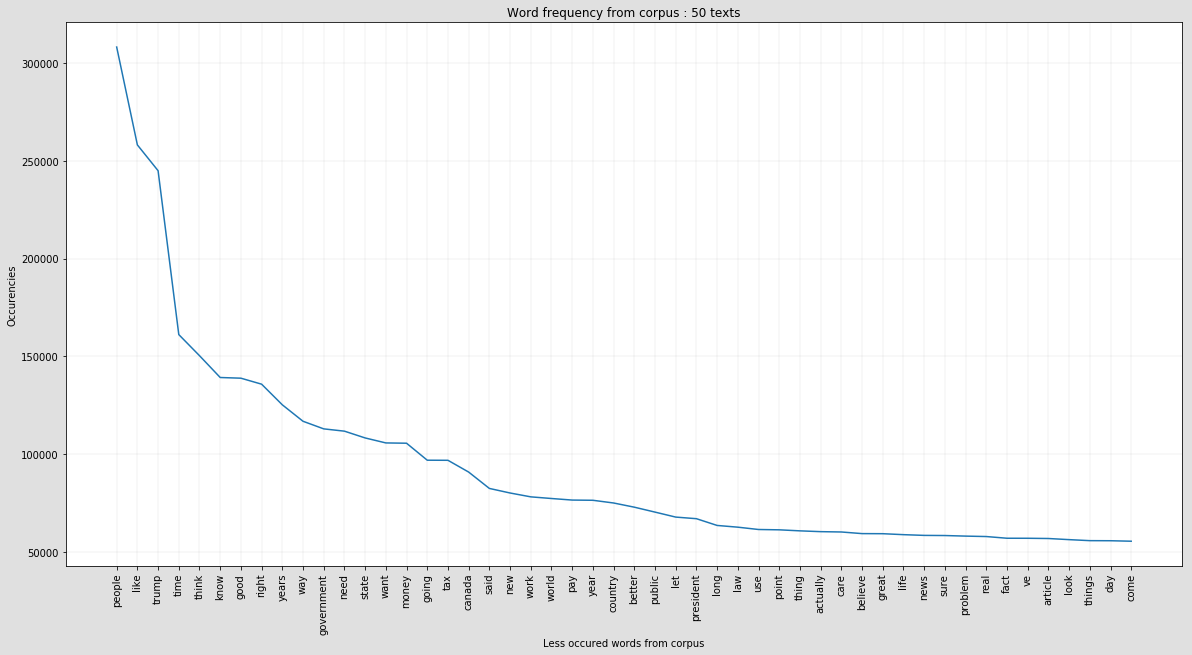

In [62]:
import p6_util_plot

item_count = 50
title = 'Word frequency from corpus : '+str(item_count)+' texts'
p6_util_plot.ser_item_occurency_plot(df_wordCounting.word,df_wordCounting.counting,item_count\
                                     , title, p_x_title="Less occured words from corpus", p_y_title="Occurencies", \
                                     p_reverse=True)

    We can see that there are words that are unknown in any NLP vocabulary.
    Then, 2 questions are raising : 
        1) What is the proportion of unknow words into toxic text?
        2) Is there a correlation between toxic texts and unknown words?

    For more clarity for words frequency interpretation, most current words from NLP are removed using 
    stop words from NLTK.

## <font color=blus>1.3. Split data as train and test dataset</font>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train['comment_text'],df_train['target'],test_size=0.33, random_state=42)

print("Train dataset: X = {} Label= {}".format(X_train.shape, y_train.shape))
print("Test dataset:  X = {} Label= {}".format(X_test.shape,  y_test.shape))

In [30]:
import random

print("")
index_train_ref = random.randint(0,X_train.shape[0])
print("Train Reference index = {}".format(index_train_ref))

index_test_ref = random.randint(0,X_test.shape[0])
print("Test Reference index  = {}".format(index_test_ref))



Train Reference index = 104368
Test Reference index  = 52326


In [31]:
print(X_train.iloc[index_train_ref])
print(y_train.iloc[index_train_ref])
print("")
print(X_test.iloc[index_test_ref])
print(y_test.iloc[index_test_ref])


may this us seal rest in peace! he made the ultimate sacrifice while in service to our country.
0.0

it's all about the publicity.
0.0


## <font color=blus>1.4. Backup / restore train and test dataset </font>

In [2]:
import pandas as pd
import p5_util

filename_train = './data/df_train.dump'
filename_test  = './data/df_test.dump'

if False: 
    df_train = pd.DataFrame({'X':X_train, 'y':y_train})
    df_test  = pd.DataFrame({'X':X_test, 'y':y_test})
    
    p5_util.object_dump(df_train,filename_train)
    p5_util.object_dump(df_test,filename_test)
    
else : 
    df_train = p5_util.object_load(filename_train)
    df_test  = p5_util.object_load(filename_test)

print("")
print("Shape of train corpus : = {}".format(df_train.shape))
print("Shape of test corpus  : = {}".format(df_test.shape))

p5_util.object_load : fileName= ./data/df_train.dump
p5_util.object_load : fileName= ./data/df_test.dump

Shape of train corpus : = (1209265, 2)
Shape of test corpus  : = (595609, 2)


In [3]:
try :
    del(X_train)
    print("Object deleted!")
except NameError:
    print("Object not defined!")
try :
    del(X_test)
    print("Object deleted!")
except NameError:
    print("Object not defined!")


Object not defined!
Object not defined!


In [4]:
df_test.iloc[0].X

'what a breathe of fresh air to have someone who embraces common sense values, instead of the leadership we have in canada, that is clearly on a different page, perhaps reading from a different book.'

# <font color=blus>2x. Data preparation with `DataPreparator`</font>

In [5]:
import DataPreparator

dataPreparator_train = DataPreparator.DataPreparator(min_doc_len=2)

sample_count = 5000
dataPreparator_train.fit(df_train.X[:sample_count].values,y= df_train.y[:sample_count].values)

X_train,y_train = dataPreparator_train.transform(df_train.X[:sample_count].values,y= df_train.y[:sample_count].values)


***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens

***ERROR : empy list of tokens


In [22]:
dataPreparator_train.max_length

112

In [19]:
dataPreparator_test  = DataPreparator.DataPreparator(min_doc_len=4, \
                                             tokenizer = dataPreparator_train.tokenizer,\
                                             max_padding_length = dataPreparator_train.max_padding_length)

dataPreparator_test.fit(df_test.X[:sample_count].values,y= df_test.y[:sample_count].values)
X_test,y_test = dataPreparator_test.transform(df_test.X[:sample_count].values,y= df_test.y[:sample_count].values)

In [20]:
X_train.shape,X_test.shape

((45347, 112), (45432, 112))

In [21]:
import numpy as np
import p5_util

filename_train = './data/DataPreparator_train.dump'
filename_test = './data/DataPreparator_test.dump'

if True :
    p5_util.object_dump(dataPreparator_train,filename_train)
    p5_util.object_dump(dataPreparator_test,filename_test)
else : 
    dataPreparator_train = p5_util.object_load(filename_train)
    dataPreparator_test = p5_util.object_load(filename_test)
    
print("")
print("DataPretarator train lenth= {}".format(len(dataPreparator_train)))
print("DataPretarator test lenth=  {}".format(len(dataPreparator_test)))



DataPretarator train lenth= 45347
DataPretarator test lenth=  45432


# <font color=blus>2. Data preparation</font>

## <font color=blus>2.1. Corpus tokenization</font>

All stop-words are removed from any text.

Sentences with `length < min_len` are removed from corpus.

For memory efficiency, this process is splitted into `n_iteration` steps.

For each iteration :

    Corpus rows are slided with slide length = slide_length.

    A list of tokens free of stop words is built 
    
    This list of tokens is aggregated with the all lists from previous steps.

This process may take around 5mn.

In [33]:
import p9_util
matrix_corpus, keras_tokenizer = p9_util.bow_matrix_build(df.text, maxLength=3, tokenizer=None, is_padded=True)
print()
print(matrix_corpus)


[[3 1 0]
 [4 5 0]
 [6 1 0]
 [2 0 0]
 [2 0 0]
 [7 0 0]]


In [6]:
import p9_util
df_train_free_stopword = p9_util.corpus_tokenize(df_train.X, target=df_train.y,\
                                                 slide_length = 100000, \
                                                 min_token_len=2, max_token_len=15,\
                                                 min_doc_len=5, max_doc_len=500)


 lapsed time for iteration 11 = 18.0 / (start,end)=(1100000,1200000)
Number of prepared texts= 1209265


In [128]:
df_train_free_stopword.sample(3)

,count,target,text
92098,19,0.000000,"[eric, ryan, listed, trump, supporter, matthew..."
652234,5,0.000000,"[tell, richard, jt, canadians, puts]"
1637396,37,0.166667,"[guns, kill, people, true, guns, kill, people,..."


In [7]:
import p9_util
df_test_free_stopword = p9_util.corpus_tokenize(df_test.X, target=df_test.y,\
                                                 slide_length = 100000, \
                                                 min_token_len=2, max_token_len=15,\
                                                 min_doc_len=5, max_doc_len=500)


 lapsed time for iteration 4 = 11.0 / (start,end)=(400000,500000)
Number of prepared texts= 595609


In [9]:
df_test_free_stopword.shape, df_test.X.shape

((519280, 3), (595609,))

In [57]:
df_test_free_stopword.sample(3)

,count,target,text
1320268,63,0.000000,article published media outlet marco polo cite...
578855,35,0.578947,obama knows shame trudeau charm smooth talking...
859536,6,0.000000,barista honest work people like value


In [39]:
print(df_test_free_stopword['count'].describe(), df_train_free_stopword['count'].describe())
max_test_doc_len = df_test_free_stopword['count'].max()
max_train_doc_len = df_train_free_stopword['count'].max()

max_corpus_len = max(max_test_doc_len,max_train_doc_len)
max_corpus_len

count    519280.000000
mean         26.293339
std          20.902139
min           5.000000
25%          10.000000
50%          19.000000
75%          36.000000
max         156.000000
Name: count, dtype: float64 count    1.054585e+06
mean     2.628429e+01
std      2.090143e+01
min      5.000000e+00
25%      1.000000e+01
50%      1.900000e+01
75%      3.600000e+01
max      3.040000e+02
Name: count, dtype: float64


304

## <font color=blus>2.2. Backup / restore train and test tokenized dataset </font>

#### <font color='blus'>Save / restore of list of tokenized sentences free of stop words.</font>

In [1]:
import p5_util

filename_train = './data/df_train_free_stopword.dump'
filename_test  = './data/df_test_free_stopword.dump'

if False: 
    p5_util.object_dump(df_train_free_stopword,filename_train)
    p5_util.object_dump(df_test_free_stopword,filename_test)
    
else : 
    df_train_free_stopword = p5_util.object_load(filename_train)
    df_test_free_stopword = p5_util.object_load(filename_test)

print("")
print("Shape of train corpus sample free of stop words: = {}".format(df_train_free_stopword.shape))
print("Shape of test corpus sample free of stop words : = {}".format(df_test_free_stopword.shape))

p5_util.object_load : fileName= ./data/df_train_free_stopword.dump
p5_util.object_load : fileName= ./data/df_test_free_stopword.dump

Shape of train corpus sample free of stop words: = (1054585, 3)
Shape of test corpus sample free of stop words : = (519280, 3)


In [2]:
max_test_doc_len = df_test_free_stopword['count'].max()
max_train_doc_len = df_train_free_stopword['count'].max()

max_corpus_len = max(max_test_doc_len,max_train_doc_len)
print("Max corpus length= {}".format(max_corpus_len))

Max corpus length= 304


## <font color=blus>2.3. Checking tokenization process</font>

In [3]:
df_test_free_stopword.sample(3)

,count,target,text
1068664,71,0.0,"[point, election, upper, class, control, speak..."
1646085,29,0.0,"[coal, miners, people, dont, agree, assessment..."
510985,77,0.0,"[weather, service, thermometers, accurate, par..."


In [4]:
df_train_free_stopword.sample(3)

,count,target,text
1601611,36,0.0,"[huge, ouchespecially, wasis, fixed, incomes, ..."
1403857,5,0.5,"[youre, antifascist, youre, decent, human]"
832416,15,0.0,"[wouldnt, bad, team, hadnt, started, jays, aff..."


## <font color=blus>2.4. NLP corpus processing with Spacy</font>

    Spacy provides 6 pre-trained models for english language.
    
    The one used is en_core_web_sm

In [22]:
import spacy
spacy_nlp = spacy.load('en_core_web_sm')

### <font color=blus>2.4.1. Lemmatization</font>

In [17]:
ser_sentence = df_test_free_stopword.text.apply(lambda list_token : " ".join(list_token))

df_test_free_stopword['sentence'] = ser_sentence.copy()
df_test_free_stopword.columns

Index(['count', 'target', 'text', 'sentence'], dtype='object')

In [19]:
df_test_free_stopword['lemma'] = df_test_free_stopword.sentence.apply(lambda sentence : [word.lemma_ for word in nlp(sentence)])

In [20]:
df_test_free_stopword.sample(3)

,count,target,text,sentence,lemma
1138651,15,0.4,"[oh, bet, far, lunatic, lefties, amke, ottawa,...",oh bet far lunatic lefties amke ottawa liberal...,"[oh, bet, far, lunatic, lefty, amke, ottawa, l..."
1093362,74,0.0,"[nope, reasons, care, expensive, insurance, pr...",nope reasons care expensive insurance profits ...,"[nope, reason, care, expensive, insurance, pro..."
292130,37,0.0,"[narcan, doesnt, work, stuff, opioid, binds, r...",narcan doesnt work stuff opioid binds receptor...,"[narcan, do, not, work, stuff, opioid, bind, r..."


In [23]:
#df_test_free_stopword['tokens'] = df_test_free_stopword.sentence.apply(lambda sentence : [word.lemma_ for word in nlp(sentence)])
import p9_util
df_test_free_stopword['tokens'] = df_test_free_stopword.sentence.apply(lambda document: [token.lemma_ for token in spacy_nlp(document) if p9_util.spacy_is_token_valid(token)]  )


/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.
W0818 17:02:44.270750 139861934581568 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0818 17:02:44.271674 139861934581568 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

W0818 17:0

In [28]:
len(df_test_free_stopword.loc[1138651].tokens)

15

## <font color=blus>2.5. Tokenized corpus Analysis</font>


    Deep Learning algorithms used in this project require fixed text length as input.
    Maximum text lentgh is fixed from statistical analysis.
    
    Once done, all documents from corpus will be padded to this maximum text length value, if required.

count    1.054585e+06
mean     2.628429e+01
std      2.090143e+01
min      5.000000e+00
25%      1.000000e+01
50%      1.900000e+01
75%      3.600000e+01
max      3.040000e+02
Name: count, dtype: float64
 
Max train document length= 304


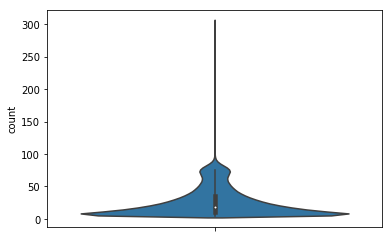

In [45]:
import seaborn as sns


print(df_train_free_stopword['count'].describe())
z_=sns.violinplot( y=df_train_free_stopword['count'] )
max_train_len = df_train_free_stopword['count'].max()
print(" ")
print("Max train document length= {}".format(max_train_len))

count    519280.000000
mean         26.293339
std          20.902139
min           5.000000
25%          10.000000
50%          19.000000
75%          36.000000
max         156.000000
Name: count, dtype: float64
 
Max test document length= 156


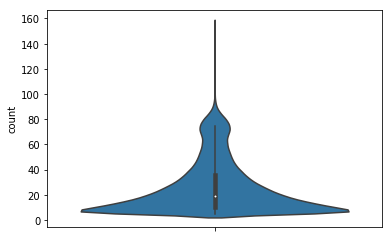

In [44]:
import seaborn as sns


print(df_test_free_stopword['count'].describe())
z_=sns.violinplot( y=df_test_free_stopword['count'] )
max_test_len = df_test_free_stopword['count'].max()
print(" ")
print("Max test document length= {}".format(max_test_len))

    Both, train and test datasets have approximatively same distribution considering text length.

    Considering above distribution, text max_length is the value in a such way 100% of dataset is processed.
    

# <font color='blus'>2. Corpus sample vectorization</font>

## <font color='blus'>2.1. Sampling tokenized corpus</font>

### <font color=blus>2.1.1. Sampling train and test dataset</font>

    When no ratio is provided, then the full dataset is processed.
    Files are then saved with '_full' extension.
    
    Otherwise, a part of dataset is processed along with ratio value.
    In this case, files are saved with no extension.

In [63]:
ratio=0.3

In [64]:
import p9_util

if ratio > 0. :
    extension='_part'
    n_sample = int(len(df_train_free_stopword)*ratio)
    df_train_free_stopword_sample = df_train_free_stopword.sample(n_sample)
    
    n_sample = int(len(df_test_free_stopword)*ratio)
    df_test_free_stopword_sample  = df_test_free_stopword.sample(n_sample)
else :
    extension='_full'
    
print("Train dataframe shape= {}".format(df_train_free_stopword_sample.shape))
print("Test dataframe shape=  {}".format(df_test_free_stopword_sample.shape))

Train dataframe shape= (315978, 3)
Test dataframe shape=  (155594, 3)


## <font color='blus'>2.1. TFIDF processing</font>

In [104]:
df_train_free_stopword_sample.columns

Index(['count', 'target', 'text'], dtype='object')

In [105]:
import p9_util
ser_X_train_sample = df_train_free_stopword_sample['text']
vectorizer_sample, csr_matrix_train_sample = \
p9_util.tfidf_vectorization(ser_X_train_sample, vectorizer=None, \
                            ngram_range=(1, 3),max_features=1000)

ser_X_test_sample = df_test_free_stopword_sample['text']
vectorizer_sample, csr_matrix_test_sample = \
p9_util.tfidf_vectorization(ser_X_test_sample, vectorizer=vectorizer_sample, \
                            ngram_range=(1, 3),max_features=1000)


Fit vectorizer pipeline...
Transform data with vectorizer...

Transform data with vectorizer...


In [106]:
y_train_sample = df_train_free_stopword_sample['target']
y_test_sample  = df_test_free_stopword_sample['target']

In [107]:
print("")
print("Shape of vectorized X_train sample= {}".format(csr_matrix_train_sample.shape))
print("Shape of y_train_sample= {}".format(y_train_sample.shape))
print("")
print("Shape of vectorized X_test sample= {}".format(csr_matrix_test_sample.shape))
print("Shape of y_test_sample= {}".format(y_test_sample.shape))


Shape of vectorized X_train sample= (315978, 1000)
Shape of y_train_sample= (315978,)

Shape of vectorized X_test sample= (155594, 1000)
Shape of y_test_sample= (155594,)


    Save dataset sample

In [108]:
import numpy as np
import p5_util

if True :
    filename = './data/vectorizer'+extension+'_tfidf.dump'
    p5_util.object_dump(vectorizer_sample,filename)
    
    filename = './data/csr_matrix_train_sample'+extension+'_tfidf.dump'
    p5_util.object_dump(csr_matrix_train_sample,filename)

    filename = './data/csr_matrix_test_sample'+extension+'_tfidf.dump'
    p5_util.object_dump(csr_matrix_test_sample,filename)

    filename = './data/y_train_sample'+extension+'_tfidf.dump'
    p5_util.object_dump(y_train_sample,filename)

    filename = './data/y_test_sample'+extension+'_tfidf.dump'
    p5_util.object_dump(y_test_sample,filename)
else : 
    filename = './data/vectorizer'+extension+'_tfidf.dump'
    vectorizer_sample = p5_util.object_load(filename)
    
    filename = './data/csr_matrix_train_sample'+extension+'_tfidf.dump'
    csr_matrix_train_sample = p5_util.object_load(filename)

    filename = './data/csr_matrix_test_sample'+extension+'_tfidf.dump'
    csr_matrix_test_sample = p5_util.object_load(filename)

    filename = './data/y_train_sample'+extension+'_tfidf.dump'
    y_train_sample = p5_util.object_load(filename)

    filename = './data/y_test_sample'+extension+'_tfidf.dump'
    y_test_sample = p5_util.object_load(filename)

print("")
print("Sample of train CSR matrix shape = {}".format(csr_matrix_train_sample.shape))
print("Sample of train target shape     = {}".format(y_train_sample.shape))
print("")
print("Sample of test CSR matrix shape  = {}".format(csr_matrix_test_sample.shape))
print("Sample of test target shape      = {}".format(y_test_sample.shape))


Sample of train CSR matrix shape = (315978, 1000)
Sample of train target shape     = (315978,)

Sample of test CSR matrix shape  = (155594, 1000)
Sample of test target shape      = (155594,)


## <font color='blus'>2.2. BOW processing</font>

    The whole corpus, free of stop words, handles arround 2 millions texts.
    
    Each tokenized sentence is converted back into plain text sentence. This lead to a list of sentences.
    
    This list of sentences will feed countvectorizer in order to proceed to BOW based on word counting.

In [327]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()

csr_matrix_train_sample_bow = vectorizer.fit_transform(df_train_free_stopword_sample['text'])
print(csr_matrix_train_sample_bow.shape)

(285685, 112913)


In [329]:
csr_matrix_test_sample_bow = vectorizer.transform(df_test_free_stopword_sample['text'])
print(csr_matrix_test_sample_bow.shape)

(140733, 112913)


    Vectorization leads to a dictionary of near to 280 000 words for closed to 2 millions texts.

#### Save / Reload vectorized corpus as well as vectorizer

    Save / reload operations applies on vectorized corpus withous any stop words.
    
    Change flag True / False depending on operation to proceed.

In [331]:
import numpy as np
import p5_util

if False :
    filename = './data/vectorizer'+extension+'_bow.dump'
    p5_util.object_dump(vectorizer,filename)
    
    filename = './data/csr_matrix_train_sample'+extension+'_bow.dump'
    p5_util.object_dump(csr_matrix_train_sample_bow,filename)

    filename = './data/csr_matrix_test_sample'+extension+'_bow.dump'
    p5_util.object_dump(csr_matrix_test_sample_bow,filename)

    filename = './data/y_train_sample'+extension+'_bow.dump'
    p5_util.object_dump(y_train_sample,filename)

    filename = './data/y_test_sample'+extension+'_bow.dump'
    p5_util.object_dump(y_test_sample,filename)
else : 
    filename = './data/vectorizer'+extension+'_bow.dump'
    vectorizer = p5_util.object_load(filename)
    
    filename = './data/csr_matrix_train_sample'+extension+'_bow.dump'
    csr_matrix_train_sample_bow = p5_util.object_load(filename)

    filename = './data/csr_matrix_test_sample'+extension+'_bow.dump'
    csr_matrix_test_sample_bow = p5_util.object_load(filename)

    filename = './data/y_train_sample'+extension+'_bow.dump'
    y_train_sample = p5_util.object_load(filename)

    filename = './data/y_test_sample'+extension+'_bow.dump'
    y_test_sample = p5_util.object_load(filename)

print("")
print("Sample of train CSR matrix BOW shape = {}".format(csr_matrix_train_sample_bow.shape))
print("Sample of train target shape         = {}".format(y_train_sample.shape))
print("")
print("Sample of test CSR matrix bOW shape  = {}".format(csr_matrix_test_sample_bow.shape))
print("Sample of test target shape          = {}".format(y_test_sample.shape))    

p5_util.object_load : fileName= ./data/vectorizer_part_bow.dump
p5_util.object_load : fileName= ./data/csr_matrix_train_sample_part_bow.dump
p5_util.object_load : fileName= ./data/csr_matrix_test_sample_part_bow.dump
p5_util.object_load : fileName= ./data/y_train_sample_part_bow.dump
p5_util.object_load : fileName= ./data/y_test_sample_part_bow.dump

Sample of train CSR matrix BOW shape = (285685, 112913)
Sample of train target shape         = (285685,)

Sample of test CSR matrix bOW shape  = (140733, 112913)
Sample of test target shape          = (140733,)


    We note that some words does not exist in the natural language, for orthographic purpose, 
    such as 'minnesota', 'minions' or for obfuscation purpose such as 'aaaaaaaao'
    
    Other words are intuitively related to polemical discussion, such as 'mindless', 'miserable' or 'minority'.

    Let's evaluate what is probability to encounter a word out of NLP vocabulary for toxicity scores >0 
    compared to toxicity scores ==0.
    
    For doing so, texts with target >0. are selected from corpus.

# <font color=blus>3. Corpus sample tokenization</font>


Each text from both `df_train_free_stopword_sample` and `df_test_free_stopword_sample` are converted into a list of tokens using `simple_preprocess` function from `gensim.util` package.

The variable `list_train_corpus_label` is a list of tuples `(list_token, target)`.

For each text, `list_token` is the list of tokenized text while `target` holds toxicity value.

Equivalent transformation over test dataset also leads to list of tuple `(list_token, target)`.


In [65]:
df_train_free_stopword['text'].iloc[0]

'sure understand article agree foxx news especially prime time lineup generally taken stunningly absurd cheap shots directed hillary clinton character ridiculous makes wonder people like jessie waters shawn hannity air think reason foxx cable news high ratings high percentage viewers watch simply fun silly comments believe felt hillary treated unfairly cnn cbc newspaper democrats clearly problem midst mind boggling inept white house recorded history democrats unable vacuum presidential space far shoo win seats midterms elections sorry feel facts support argument democrats mistreating clinton'

In [66]:
list_train_corpus_label = [ (gensim.utils.simple_preprocess(df_train_free_stopword_sample['text'].loc[index], \
                            deacc=True, min_len=2), df_train_free_stopword_sample['target'].loc[index]) \
                           for index in df_train_free_stopword_sample.index]
X_train_tokenized_sample = [list_train_corpus_label[i][0] for i in range(0, len(list_train_corpus_label),1)]
y_train_sample = [list_train_corpus_label[i][1] for i in range(0, len(list_train_corpus_label),1)]

In [67]:
list_test_corpus_label = [ (gensim.utils.simple_preprocess(df_test_free_stopword_sample['text'].loc[index], \
                            deacc=True, min_len=2), df_test_free_stopword_sample['target'].loc[index]) \
                           for index in df_test_free_stopword_sample.index]

X_test_tokenized_sample = [list_test_corpus_label[i][0] for i in range(0, len(list_test_corpus_label),1)]
y_test_sample = [list_test_corpus_label[i][1] for i in range(0, len(list_test_corpus_label),1)]

#### Check if there is no worthy values for targets

In [68]:
print("Worthy values for target into train dataset = "+str(len(np.where(np.array(y_train_sample) <0.)[0])))
print("Worthy values for target into test dataset = "+str(len(np.where(np.array(y_test_sample) <0.)[0])))

Worthy values for target into train dataset = 0
Worthy values for target into test dataset = 0


In [78]:
ser_len = pd.Series([len(tokenized_text) for tokenized_text in X_train_tokenized_sample])

ser_len.sample(3)

54603     22
298120    23
194126    39
dtype: int64

In [92]:
df_train_tokenized_sample = pd.DataFrame({'count':ser_len.tolist() ,'tokenized':X_train_tokenized_sample, 'target':y_train_sample})
df = df_train_tokenized_sample.sample(3)

index = df.index[-1]
print(df.loc[index]['tokenized'])
print("")

print(df_train_free_stopword_sample.iloc[index]['text'])

['control', 'union', 'management', 'entering', 'bargaining', 'sessions', 'means', 'collectively', 'come', 'agreement', 'employee', 'management', 'union', 'control', 'employers', 'taxpayers', 'management', 'problem', 'lack', 'ability', 'negotiate', 'minutes', 'read', 'benefits', 'unions', 'particularly', 'employees', 'benefited', 'union', 'demands', 'interesting', 'informative', 'union', 'firmly', 'believe', 'valuable']

control union management entering bargaining sessions means collectively come agreement employee management union control employers taxpayers management problem lack ability negotiate minutes read benefits unions particularly employees benefited union demands interesting informative union firmly believe valuable


In [94]:
ser_len = pd.Series([len(tokenized_text) for tokenized_text in X_test_tokenized_sample])
ser_len.sample(3)

14732     8
70154    16
33741     5
dtype: int64

In [95]:
df_test_tokenized_sample = pd.DataFrame({'count':ser_len.tolist(),\
                                         'tokenized':X_test_tokenized_sample,\
                                         'target':y_test_sample})

df = df_test_tokenized_sample.sample(3)

index = df.index[-1]
print(df.loc[index]['tokenized'])
print("")

print(df_test_free_stopword_sample.iloc[index]['text'])

['nice', 'hate', 'speech', 'march', 'armband']

nice hate speech march armband


## <font color=blus> 3.1. Backup / Restore sampled tokenized corpus</font>

In [97]:
import p5_util

if False :
    filename = './data/df_train_tokenized_sample'+extension+'.dump'
    p5_util.object_dump(df_train_tokenized_sample,filename)
    
    filename = './data/df_test_tokenized_sample'+extension+'.dump'
    p5_util.object_dump(df_test_tokenized_sample,filename)
else : 
    filename = './data/df_train_tokenized_sample'+extension+'.dump'
    df_train_tokenized_sample = p5_util.object_load(filename)
    
    filename = './data/df_test_tokenized_sample'+extension+'.dump'
    df_test_tokenized_sample = p5_util.object_load(filename)

print("")
print("Sample of train dataframe tokenized shape= {}".format(df_train_tokenized_sample.shape))
print("Sample of test dataframe tokenized shape = {}".format(df_test_tokenized_sample.shape))


p5_util.object_load : fileName= ./data/df_train_tokenized_sample_part.dump
p5_util.object_load : fileName= ./data/df_test_tokenized_sample_part.dump

Sample of train dataframe tokenized shape= (315978, 3)
Sample of test dataframe tokenized shape = (155594, 3)


## <font color=blus>3.3. Tokenized corpus truncation and padding</font>

In [10]:
max_length = max_train_len

print("\nMaximum text length= {}".format(max_length))


Maximum text length= 97


    Texts are filtered depending max_length.
    Empty documents are removed from dataset.

In [11]:
import p9_util
X_train_truncated, y_train_truncated = p9_util.X_y_truncate_max_length(df_train_tokenized_sample['tokenized'],\
                                                                       df_train_tokenized_sample['target'],\
                                                                       max_length)

X_test_truncated, y_test_truncated = p9_util.X_y_truncate_max_length(df_test_tokenized_sample['tokenized'],\
                                                                     df_test_tokenized_sample['target'],\
                                                                     max_length)

print("Size of truncated (X,y) train : {}".format(len(X_train_truncated),len(y_train_truncated)))
print("Size of truncated (X,y) test  : {}".format(len(X_test_truncated), len(y_test_truncated)))

Size of truncated (X,y) train : 285685
Size of truncated (X,y) test  : 140733


In [33]:
df_train_tokenized_sample.iloc[0]['tokenized']

['exciting',
 'englewood',
 'alive',
 'businesses',
 'influx',
 'young',
 'residents',
 'moving']

## <font color=blus>3.4. Corpus toxicity analysis</font>

    Analysis of ratio of toxic texts in corpus, each for test and train dataset.
    Text is regarded as toxic when target score is >0.
    This means, toxicity intensity is not taken into account.

In [366]:
import numpy  as np

print("Percentage of toxics texts from train dataset= {0:.2f}%".format(100*len(np.where(y_train_truncated > 0.)[0])/len(y_train_truncated)))
print("Percentage of toxics texts from test dataset=  {0:.2f}%".format(100*len(np.where(y_test_truncated > 0.)[0])/len(y_test_truncated)))

Percentage of toxics texts from train dataset= 31.74%
Percentage of toxics texts from test dataset=  32.10%


    Let's consider toxic texts with a target score > 0.3 : 

In [367]:
import numpy  as np
score_threshold = 0.3
print("Percentage of toxics texts > {1} from train dataset= {0:.2f}%".format(100*len(np.where(y_train_truncated > score_threshold)[0])/len(y_train_truncated), score_threshold))
print("Percentage of toxics texts > {1} from test dataset=  {0:.2f}%".format(100*len(np.where(y_test_truncated > score_threshold)[0])/len(y_test_truncated), score_threshold))

Percentage of toxics texts > 0.3 from train dataset= 12.02%
Percentage of toxics texts > 0.3 from test dataset=  12.02%


    On the display above, for both train and test datasets, there is the same percentage of toxics texts.

    Let's convert target values as int ranging from 0 to 10.
    This is done for the easy of representation of the toxic distribution.

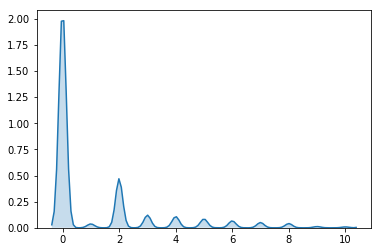

In [369]:
import seaborn as sns

_ = sns.kdeplot(np.ndarray.astype(np.round(y_train_truncated*10),int), shade=True)

    It can be shown that :
        --> Free toxic texts are the most frequent state into discussions.
        --> Highly toxic texts are very few in discussions.
        --> Frequency of toxic texts decreases along with toxicity intensity.
        
    Data model is not balanced between free toxic texts (mostly 90%) and texts with toxicity indicator value >0.
    
    This may lead to some hardness when for training an algorithm to predict toxicity values with so few 
    toxic samples.
    
        

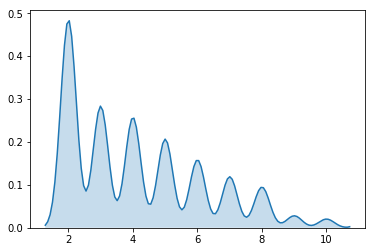

In [372]:
import seaborn as sns

score_threshold =0.2
arr_index = np.where(np.array(y_train_truncated) >= score_threshold)[0]
y_train_token_threshold = np.array(y_train_truncated)[arr_index]

 
_=sns.kdeplot(np.ndarray.astype(np.round(y_train_token_threshold*10),int), shade=True)

    Graphic above leads to consider toxicity scores as multivariate outliers.
    
    Applied method : 
    --------------
        1) Binary classification of observation: outlier or not
        2) Applying a regression model for scoring observations issues from previous binary classification.

## <font color=blus>3.5. BOW Keras vectorization and padding </font>

    Keras tokenizer is used in order to digitalize corpus.
    Each document from corpus is turned into a sequence of integers.
    Doing thus, a vocabulary set is built through tokenizer.
    
    NN require fixed text length to be processed. Then truncation and padding are applied.
    
    Texts with length <= max_length are taken into account.
    For texts with length < max_length, then a padding procced on right size is applied on.


In [79]:
print(df_train_free_stopword['text'].iloc[0])
print("")
print(len(df_train_free_stopword['text'].iloc[0]))

understand article agree especially prime lineup generally taken stunningly absurd cheap shots directed hillary clinton character ridiculous makes wonder people jessie waters shawn hannity think reason cable ratings percentage viewers watch simply silly comments believe hillary treated unfairly newspaper democrats clearly problem midst boggling inept white house recorded history democrats unable vacuum presidential space seats midterms elections sorry facts support argument democrats mistreating clinton

508


In [72]:
import keras
print("Building vocabulary from texts...")
keras_tokenizer = keras.preprocessing.text.Tokenizer()
keras_tokenizer.fit_on_texts(df_train_free_stopword['text'])
vocab_size = len(keras_tokenizer.word_index) + 1

print("Encoding texts into seqences...")
# Documents are encoded with integers; sequences are integers
X_train_encoded = keras_tokenizer.texts_to_sequences(df_train_free_stopword['text'])
print(" ")
print("Number of documents as BOW=         {}".format(len(X_train_encoded)))
print("Vocabulary size from keras tokenizer= {}".format(vocab_size))

Number of documents as BOW=         952284
Vocabulary size from keras tokenizer= 201754


In [101]:
import keras
help(keras.preprocessing.text.Tokenizer)

Help on class Tokenizer in module keras_preprocessing.text:

class Tokenizer(builtins.object)
 |  Text tokenization utility class.
 |  
 |  This class allows to vectorize a text corpus, by turning each
 |  text into either a sequence of integers (each integer being the index
 |  of a token in a dictionary) or into a vector where the coefficient
 |  for each token could be binary, based on word count, based on tf-idf...
 |  
 |  # Arguments
 |      num_words: the maximum number of words to keep, based
 |          on word frequency. Only the most common `num_words-1` words will
 |          be kept.
 |      filters: a string where each element is a character that will be
 |          filtered from the texts. The default is all punctuation, plus
 |          tabs and line breaks, minus the `'` character.
 |      lower: boolean. Whether to convert the texts to lowercase.
 |      split: str. Separator for word splitting.
 |      char_level: if True, every character will be treated as a token.


In [103]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
help(CountVectorizer)

Help on class CountVectorizer in module sklearn.feature_extraction.text:

class CountVectorizer(sklearn.base.BaseEstimator, VectorizerMixin)
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : string {'filename', 'file', 'content'}
 |      If 'filename', the sequence passed as an argument to fit is
 |      expected to be a list of filenames that need reading to fetch
 |      the raw content to analyze.
 |  
 |      If 'file', the sequence items must have a 'read' method (file-like
 |      object) that is called to fetc

In [135]:
slide = 100
len(X_train_encoded)
iterate  = len(X_train_encoded)/slide
iterate

9522.84

In [143]:
slide_start = 0
X = np.zeros(vocab_size).reshape(1,-1)
for i in range(0, int(iterate)):
    slide_end = slide_start+slide
    X1 = keras_tokenizer.sequences_to_matrix(X_train_encoded[slide_start:slide_end], mode='tfidf')
    X = np.concatenate((X, X1), axis=0)
    slide_start=slide_end

MemoryError: 

In [97]:
text =keras_tokenizer.sequences_to_texts([X_train_encoded[0]])[0]
print(text)
print("")
print(len(text.split(" ")))
print(" ")
print(vocab_size)

understand article agree especially prime lineup generally taken stunningly absurd cheap shots directed hillary clinton character ridiculous makes wonder people jessie waters shawn hannity think reason cable ratings percentage viewers watch simply silly comments believe hillary treated unfairly newspaper democrats clearly problem midst boggling inept white house recorded history democrats unable vacuum presidential space seats midterms elections sorry facts support argument democrats mistreating clinton

64
 
201754


In [12]:
import keras
keras_tokenizer = keras.preprocessing.text.Tokenizer()

keras_tokenizer.fit_on_texts(X_train_truncated)

vocab_size = len(keras_tokenizer.word_index) + 1

# Documents are encoded with integers
X_train_encoded = keras_tokenizer.texts_to_sequences(X_train_truncated)

print("Number of documents as BOW=         {}".format(len(X_train_encoded)))
print("Vocabury size from keras tokenizer= {}".format(vocab_size))

Number of documents as BOW=         285685
Vocabury size from keras tokenizer= 110292


In [31]:
print(X_train_truncated[0])
print(X_train_encoded[0])

['exciting', 'englewood', 'alive', 'businesses', 'influx', 'young', 'residents', 'moving']
[ 5006 26261  1305   516  6033   153   587   629     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


    All tokenized texts are fixed with same length, using padding.
    Padding targets text length <= max_length.
    
    This process is applied on both train and test dataset.

In [13]:
X_train_encoded = keras.preprocessing.sequence.pad_sequences(X_train_encoded,\
                                                             maxlen=max_length, padding='post')

print("Number of padded BOW train documents= {}".format(len(X_train_encoded)))
print("Target size= .........................{}".format(len(y_train_truncated)))
print()

#Apply pre-processing over test dataset, means, encoding and padding.
#Tokenizer used is the one for X_train

X_test_encoded = keras_tokenizer.texts_to_sequences(X_test_truncated)
# 
X_test_encoded = keras.preprocessing.sequence.pad_sequences(X_test_encoded,\
                                                            maxlen=max_length, padding='post')

print("Number of padded BOW test documents=  {}".format(len(X_test_encoded)))
print("Target size= .........................{}".format(len(y_test_truncated)))

Number of padded BOW train documents= 285685
Target size= .........................285685

Number of padded BOW test documents=  140733
Target size= .........................140733


In [14]:
df_train_keras_encoded = pd.DataFrame({'encoded':X_train_encoded.tolist(), 'target':y_train_truncated})
df_test_keras_encoded  = pd.DataFrame({'encoded':X_test_encoded.tolist(),  'target':y_test_truncated})

    Dump of encoded train and test corpus along with tokenizer.
    Tokenizer holds dictionary that will be used.

In [16]:
df_train_keras_encoded.sample(3)

,encoded,target
167424,"[1102, 27428, 46829, 2047, 4175, 1224, 26409, ...",0.2
98249,"[5574, 823, 104, 582, 8675, 4815, 20496, 76, 2...",0.0
199126,"[26, 5499, 1135, 720, 15733, 1781, 132, 177, 0...",0.2


## <font color=blus>3.6. Backup / Restore BOW Keras vectorization and padding </font>

In [18]:
import numpy as np
import p5_util

if False :
    filename = "./data/keras_tokenizer"+extension+'.dump'
    p5_util.object_dump(keras_tokenizer,filename)
    
    filename = './data/df_train_keras_encoded'+extension+'.dump'
    p5_util.object_dump(df_train_keras_encoded,filename)
    
    filename = './data/df_test_keras_encoded'+extension+'.dump'
    p5_util.object_dump(df_test_keras_encoded,filename)

else : 
    filename = "./data/keras_tokenizer"+extension+'.dump'
    keras_tokenizer = p5_util.object_load(filename)
    
    filename = './data/df_train_keras_encoded'+extension+'.dump'
    df_train_keras_encoded = p5_util.object_load(filename)
    
    filename = './data/df_test_keras_encoded'+extension+'.dump'
    df_test_keras_encoded = p5_util.object_load(filename)

print("")
print("Sample of keras train dataframe encoded shape= {}".format(df_train_keras_encoded.shape))
print("Sample of keras test dataframe encoded shape = {}".format(df_test_keras_encoded.shape))
    

p5_util.object_load : fileName= ./data/keras_tokenizer_part.dump
p5_util.object_load : fileName= ./data/df_train_keras_encoded_part.dump
p5_util.object_load : fileName= ./data/df_test_keras_encoded_part.dump

Sample of keras train dataframe encoded shape= (285685, 2)
Sample of keras test dataframe encoded shape = (140733, 2)


# <font color=blus>3. CNN Estimator</font>

## <font color=blus>3.1. Loading processed dataset </font>

In [5]:
import numpy as np
import p5_util

filename = './data/keras_tokenizer'+extension+'.dump'
keras_tokenizer = p5_util.object_load(filename)

filename = './data/X_train_bow'+extension+'.dump'
X_train_bow = p5_util.object_load(filename)

filename = './data/X_test_bow'+extension+'.dump'
X_test_bow = p5_util.object_load(filename)

filename = './data/y_test_bow'+extension+'.dump'
y_test_bow = np.array(p5_util.object_load(filename))

filename = './data/y_train_bow'+extension+'.dump'
y_train_bow = np.array(p5_util.object_load(filename))

p5_util.object_load : fileName= ./data/keras_tokenizer_part.dump
p5_util.object_load : fileName= ./data/X_train_bow_part.dump
p5_util.object_load : fileName= ./data/X_test_bow_part.dump
p5_util.object_load : fileName= ./data/y_test_bow_part.dump
p5_util.object_load : fileName= ./data/y_train_bow_part.dump


In [7]:
vocab_size = len(keras_tokenizer.word_index) + 1
embedding_dim = 100
max_length = X_train_bow.shape[1]
batch_size = X_train_bow.shape[0]//10

print("\nX_train_encoded shape = {}".format(X_train_bow.shape))
print("Y train shape= {}".format(y_train_bow.shape))
print()
print("X_test_encoded shape  = {}".format(X_test_bow.shape))
print("Y test shape= {}".format(y_test_bow.shape))
print()
print("Vocabulary size= {}".format(len(keras_tokenizer.word_index) + 1))    
print()
print("Batch size= {}".format(batch_size))    
print("Input data size= {}".format(max_length))    


X_train_encoded shape = (361241, 100)
Y train shape= (361241,)

X_test_encoded shape  = (177863, 100)
Y test shape= (177863,)

Vocabulary size= 110292

Batch size= 36124
Input data size= 100


## <font color=blus>3.2. CNN processing using Keras</font>

    Convolutional layers are built with strides >0 and BOW representation of texts.
    Strides values >0 leads to consider to process Bag Of Words corpus with n-gram.


Ouptput layer dimensions for convilutional network is computed as following : 
*  <code>C = [(I-F + 2*P)/S] +1</code> where :
    * <code>C</code> is the dimension of the ouput convolutional layer;
    * <code>I</code> is the input size
    * <code>F</code> is the convolutional filter size
    * <code>P</code> is the padding size (0 here)
    * <code>S</code> is the srtides
* For 1st conv. layer : C = (100-5)/2 +1 = 17

In [8]:
print("Expected defaut dimension for 1st hidden layer : {}".format(round((100-5+2*0)/4 +1)))

Expected defaut dimension for 1st hidden layer : 25


    Strides value of S allows to regard a bulk of S consecutive words for patterns exploration. 

    For compilation, a learning rate of 0.01 increases the speed of learning. 
    
    Batch normalization for any layer insures a smooth learning, faster training, 
    avoids minima traps and neurons saturation.
    
    Batch size is selected in a such way an epoch is formed with 10 mini-batches.
    
    SGD is considered for gradient descent.

In [9]:
import p9_util
model = p9_util.keras_cnn_build((1,100), strides=4, filter_size=5, lr=1.e-2)
model.summary()

W0815 21:39:48.089928 139984829675328 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 21:39:48.091248 139984829675328 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 21:39:48.092773 139984829675328 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 21:39:48.156658 139984829675328 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 64)             32064     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             20544     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 64)             256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             20544     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 64)             256       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)            57472     
__________

In [15]:
import keras
import numpy as np

X_train_reshape = X_train_bow.reshape(-1, 1, max_length)
X_test_reshape = X_test_bow.reshape(-1,1, max_length)
print(X_train_reshape.shape)
print(np.array(y_train_bow).shape)

(361241, 1, 100)
(361241,)


In [16]:
history = model.fit(X_train_reshape, y_train_bow, batch_size=batch_size, epochs=10, 
                    verbose=1, validation_data=(X_test_reshape,y_test_bow))

W0815 21:42:02.065023 139984829675328 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 361241 samples, validate on 177863 samples
Epoch 1/10
361241/361241 [==============================] - 13s 37us/step - loss: 1.9507 - mean_absolute_error: 0.9712 - val_loss: 4.7171 - val_mean_absolute_error: 1.6942
Epoch 2/10
361241/361241 [==============================] - 11s 29us/step - loss: 0.0863 - mean_absolute_error: 0.2097 - val_loss: 1.0609 - val_mean_absolute_error: 0.8482
Epoch 3/10
361241/361241 [==============================] - 12s 32us/step - loss: 0.0639 - mean_absolute_error: 0.1890 - val_loss: 0.3163 - val_mean_absolute_error: 0.4413
Epoch 4/10
361241/361241 [==============================] - 12s 32us/step - loss: 0.0521 - mean_absolute_error: 0.1588 - val_loss: 0.1976 - val_mean_absolute_error: 0.3409
Epoch 5/10
361241/361241 [==============================] - 11s 32us/step - loss: 0.0478 - mean_absolute_error: 0.1527 - val_loss: 0.1251 - val_mean_absolute_error: 0.2569
Epoch 6/10
361241/361241 [==============================] - 13s 35us/step - loss: 0.0456

#### CNN model and history are either save or restored depending a Boolean flag.

`core_name` is a parameter identifying a model through its name.

This name may bechanged depending model parameters.

In [1]:
import keras
import p5_util
core_name = "cnn_6layers"

if False :
    model.save("model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    p5_util.object_dump(max_length, "max_length_"+core_name+".dump")
    
else :
    model = keras.models.load_model("model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    max_length = p5_util.object_load("max_length_"+core_name+".dump")

print("\nInput data length= {}".format(max_length))
model.summary()

Using TensorFlow backend.
W0815 21:45:02.055802 140642341406528 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 21:45:02.071321 140642341406528 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 21:45:02.234725 140642341406528 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 21:45:02.235442 140642341406528 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: Th

p5_util.object_load : fileName= history_cnn_6layers.dump
p5_util.object_load : fileName= max_length_cnn_6layers.dump

Input data length= 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 64)             32064     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             20544     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 64)             256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             20544     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 64)             256       
_

Model does not overfit and reach quickly a converged limit.

There is no need to apply dropout of to apply regularization over cost function.

This is due to layers batch normalization in CNN.

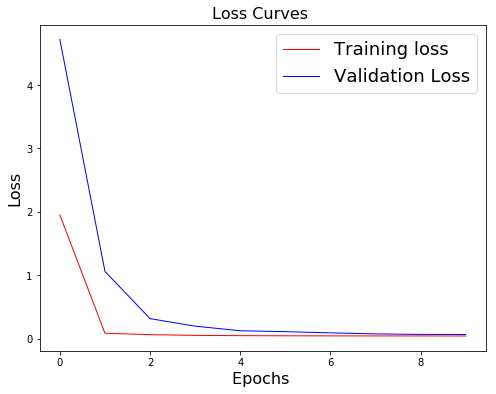

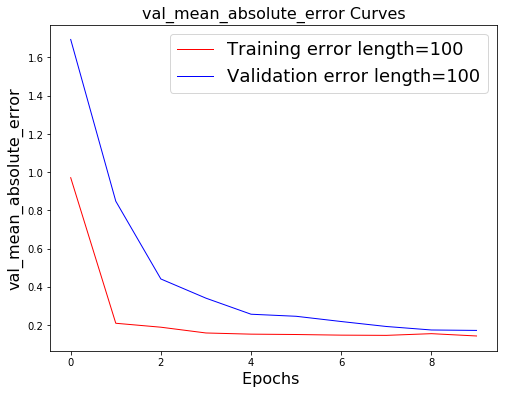

In [3]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

Check predictions considering test dataset.

In [ ]:
y_predicted = model.predict(X_test_reshape)

In [89]:
for i in range(0,10):
    delta = abs(y_test_encoded[i] - y_predicted[i])/ y_test_encoded[i]
    if y_test_encoded[i] == 0.:
        print("Value={} / Prediction={} / delta={}".format(y_test_encoded[i], y_predicted[i], delta))
    else :
        print("Value={} / Prediction={} ".format(y_test_encoded[i], y_predicted[i]))


Value=0.16666666666666666 / Prediction=[0.1482442] 
Value=0.6 / Prediction=[0.14582619] 
Value=0.0 / Prediction=[0.16317229] / delta=[inf]
Value=0.0 / Prediction=[0.11060952] / delta=[inf]
Value=0.0 / Prediction=[0.14542401] / delta=[inf]
Value=0.0 / Prediction=[0.10834374] / delta=[inf]
Value=0.0 / Prediction=[0.13461998] / delta=[inf]
Value=0.4 / Prediction=[0.13520707] 
Value=0.2 / Prediction=[0.15104234] 
Value=0.0 / Prediction=[0.21943903] / delta=[inf]


/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


RMSE for toxicity score > 0.0 = 0.30


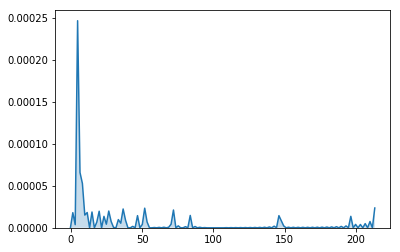

In [77]:
import numpy as np
arr_index = np.where(y_test_encoded>0.)[0]

delta = np.abs(np.sum([y_predicted[arr_index]*(-1),y_test_encoded[arr_index].reshape(-1,1)], axis=0))
delta /= y_test_encoded[arr_index].reshape(-1,1)
delta[:,0].shape, delta.min(), delta.max()

import seaborn as sns

_ = sns.kdeplot(np.ndarray.astype(np.round(delta[:,0]),int), shade=True)

mse = np.sqrt((np.square(y_predicted[arr_index] - y_test_encoded[arr_index].reshape(-1,1))).mean(axis=0))
print("RMSE for toxicity score > 0.0 = {0:1.2f}".format(mse[0]))

/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


RMSE for toxicity score <= 1.e-6 = 0.16


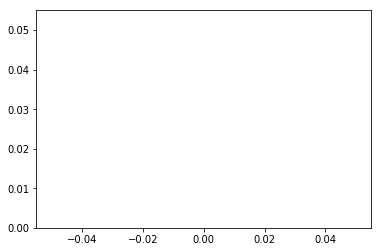

In [83]:
import numpy as np
arr_index = np.where(y_test_encoded <= 1.e-6)[0]

delta = np.abs(np.sum([y_predicted[arr_index]*(-1),y_test_encoded[arr_index].reshape(-1,1)], axis=0))
delta /= y_test_encoded[arr_index].reshape(-1,1)
delta[:,0].shape, delta.min(), delta.max()

import seaborn as sns

_ = sns.kdeplot(np.ndarray.astype(np.round(delta[:,0]),int), shade=True)

mse = np.sqrt((np.square(y_predicted[arr_index] - y_test_encoded[arr_index].reshape(-1,1))).mean(axis=0))
print("RMSE for toxicity score <= 1.e-6 = {0:1.2f}".format(mse[0]))

## <font color=blus>3.3. CNN processing with toxicity >0.0 </font>

Let's check how CNN estimatir is able to perform when all target values are >0.0 for all texts.

    Arrays values from train dataset are filtered on the criteria of tocixity index >0.

In [118]:
import p9_util
X_train_reshape_positive,  y_train_encoded_positive = p9_util.dataset_target_filter_threshold(0.0, 1, X_train_reshape, y_train_encoded)
print(X_train_reshape_positive.shape, y_train_encoded_positive.shape)

(108109, 100, 1) (108109,)


    Arrays values from test dataset are filtered

In [119]:
import p9_util

X_test_reshape_positive,  y_test_encoded_positive = p9_util.dataset_target_filter_threshold(0.0, 1, X_test_reshape, y_test_encoded)
print(X_test_reshape_positive.shape, y_test_encoded_positive.shape)

(53523, 100, 1) (53523,)


In [115]:
import p9_util
model = p9_util.build_cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 25, 64)            384       
_________________________________________________________________
batch_normalization_16 (Batc (None, 25, 64)            256       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 7, 64)             20544     
_________________________________________________________________
batch_normalization_17 (Batc (None, 7, 64)             256       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2, 64)             20544     
_________________________________________________________________
batch_normalization_18 (Batc (None, 2, 64)             256       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1, 128)            57472     
__________

In [116]:
history = model.fit(X_train_reshape_positive, y_train_encoded_positive, batch_size=batch_size, epochs=10, 
                    verbose=1, validation_data=(X_test_reshape,y_test_encoded))

Train on 108109 samples, validate on 177863 samples
Epoch 1/10
108109/108109 [==============================] - 13s 119us/step - loss: 1.5386 - mean_absolute_error: 0.8946 - val_loss: 1.2852 - val_mean_absolute_error: 0.8650
Epoch 2/10
108109/108109 [==============================] - 9s 86us/step - loss: 0.4879 - mean_absolute_error: 0.4741 - val_loss: 0.1916 - val_mean_absolute_error: 0.2953
Epoch 3/10
108109/108109 [==============================] - 9s 88us/step - loss: 0.1570 - mean_absolute_error: 0.2866 - val_loss: 0.2039 - val_mean_absolute_error: 0.3471
Epoch 4/10
108109/108109 [==============================] - 9s 87us/step - loss: 0.1161 - mean_absolute_error: 0.2596 - val_loss: 0.2240 - val_mean_absolute_error: 0.3922
Epoch 5/10
108109/108109 [==============================] - 9s 87us/step - loss: 0.0954 - mean_absolute_error: 0.2459 - val_loss: 0.2219 - val_mean_absolute_error: 0.4085
Epoch 6/10
108109/108109 [==============================] - 10s 88us/step - loss: 0.0815 - 

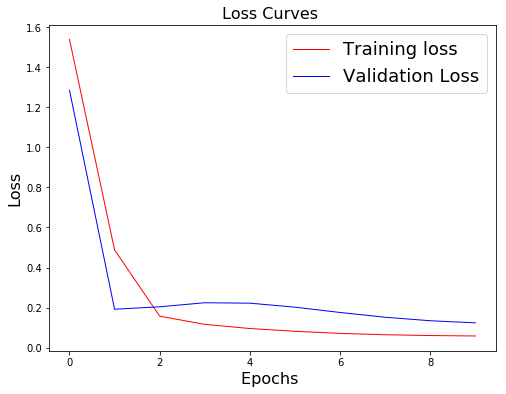

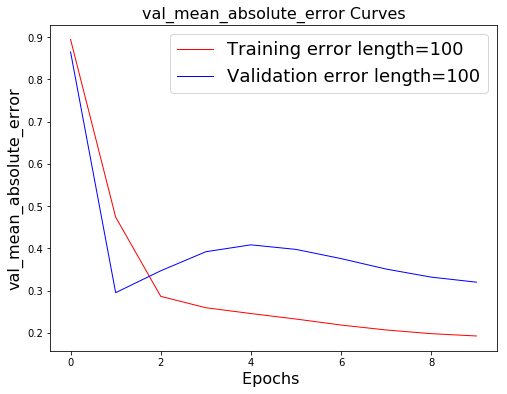

In [117]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

    It can be shown that the model behaves in a different way now.
    Estimator overfits and loss function shape are differents considering train and test dataset.
    
    Impact of unseen data representing safe texts is seen over those shapes.

## <font color=blus>3.3. CNN processing with toxicity = 0.0 </font>

Let's check how CNN estimator is able to perform when all target values are 0.0 for all texts.

This mean all texts are safe (no toxic)

In [121]:
import p9_util
threshold = 0.0
direction = 0 # == operator

X_train_reshape_threshold,  y_train_encoded_threshold = p9_util.dataset_target_filter_threshold(threshold, direction, X_train_reshape, y_train_encoded)
print(X_train_reshape_threshold.shape, y_train_encoded_threshold.shape)

X_test_reshape_threshold,  y_test_encoded_threshold = p9_util.dataset_target_filter_threshold(threshold, direction, X_test_reshape, y_test_encoded)
print(X_test_reshape_threshold.shape, y_test_encoded_threshold.shape)

(253132, 100, 1) (253132,)
(124340, 100, 1) (124340,)


In [122]:
import p9_util

model = p9_util.build_cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 25, 64)            384       
_________________________________________________________________
batch_normalization_21 (Batc (None, 25, 64)            256       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 7, 64)             20544     
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 64)             256       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2, 64)             20544     
_________________________________________________________________
batch_normalization_23 (Batc (None, 2, 64)             256       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1, 128)            57472     
__________

In [137]:
batch_size = X_train_reshape_threshold.shape[0]//10
batch_size

25313

In [124]:
history = model.fit(X_train_reshape_threshold, y_train_encoded_threshold, batch_size=batch_size, epochs=10, 
                    verbose=1, validation_data=(X_test_reshape_threshold,y_test_encoded_threshold))

Train on 253132 samples, validate on 124340 samples
Epoch 1/10
253132/253132 [==============================] - 20s 77us/step - loss: 0.8791 - mean_absolute_error: 0.5447 - val_loss: 0.4925 - val_mean_absolute_error: 0.4408
Epoch 2/10
253132/253132 [==============================] - 17s 68us/step - loss: 0.0716 - mean_absolute_error: 0.1612 - val_loss: 0.6701 - val_mean_absolute_error: 0.4578
Epoch 3/10
253132/253132 [==============================] - 18s 69us/step - loss: 0.0320 - mean_absolute_error: 0.1123 - val_loss: 26.8548 - val_mean_absolute_error: 3.1193
Epoch 4/10
253132/253132 [==============================] - 17s 68us/step - loss: 0.0931 - mean_absolute_error: 0.1802 - val_loss: 16.2426 - val_mean_absolute_error: 3.3424
Epoch 5/10
253132/253132 [==============================] - 17s 65us/step - loss: 0.0673 - mean_absolute_error: 0.1579 - val_loss: 20.0008 - val_mean_absolute_error: 3.1203
Epoch 6/10
253132/253132 [==============================] - 16s 64us/step - loss: 0.0

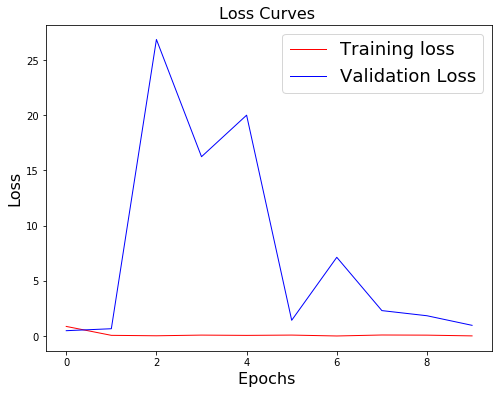

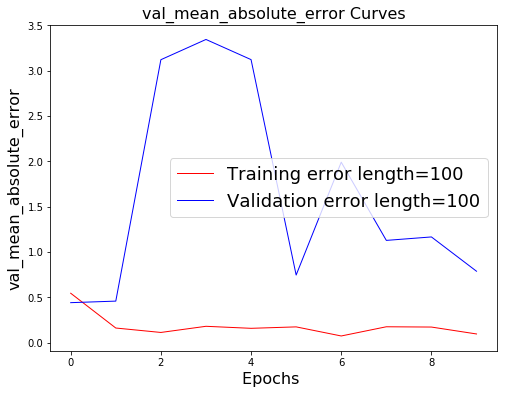

In [125]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


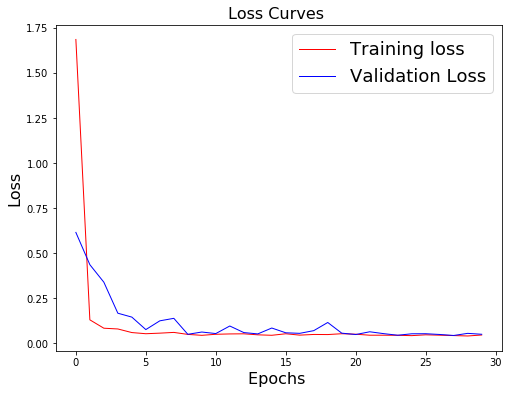

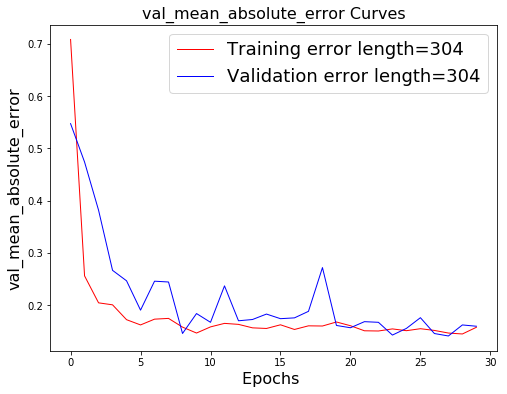

In [9]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

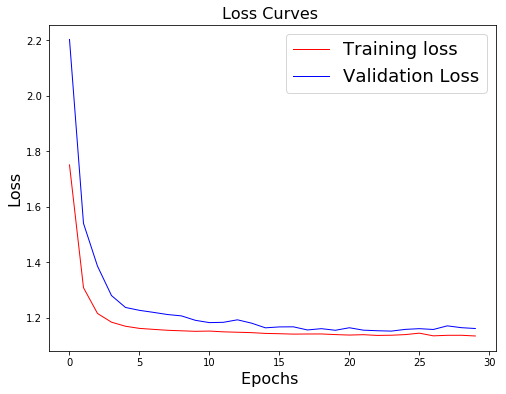

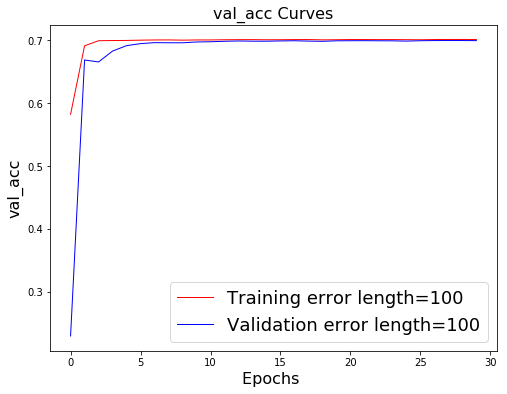

In [317]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

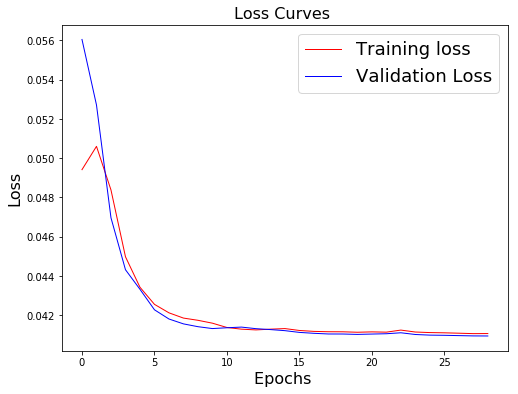

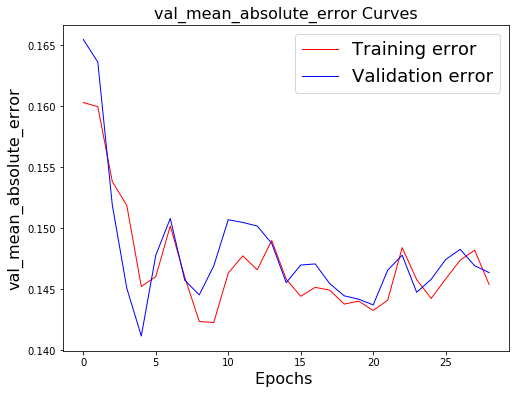

In [125]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend=str(maxlength)+' length')

### <font color=blue>Model with best performances is saved</font>

In [61]:
if True :
    model.save('./data/cnn_model.h5')

In [17]:
import p9_util
history, history_save = p9_util.remove_history_index(history, index_history=None)

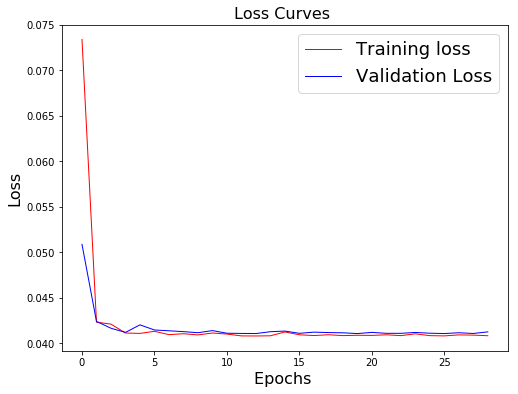

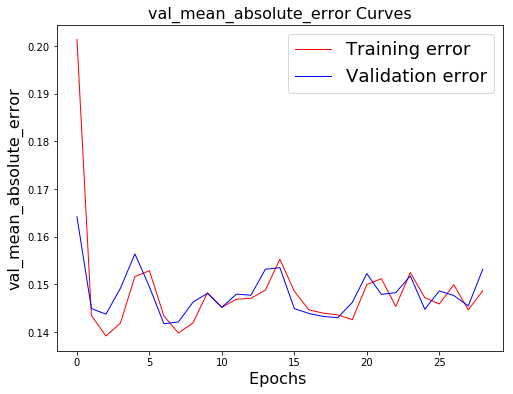

In [120]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)

### <font color='blue'> Reload best CNN model in order to compare</font>

In [49]:
import keras
if True:
    model_previous = keras.models.load_model('./data/cnn_model.h5')
    model_previous.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 19, 32)            128       
_________________________________________________________________
batch_normalization_65 (Batc (None, 19, 32)            128       
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 10, 32)            3104      
_________________________________________________________________
batch_normalization_66 (Batc (None, 10, 32)            128       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 5, 32)             3104      
_________________________________________________________________
batch_normalization_67 (Batc (None, 5, 32)             128       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 2, 16)             2576      
__________

In [50]:
history_previous = model_previous.fit(X_train_reshape, y_train, batch_size=batch_size, epochs=50, verbose=1, validation_data=(X_test_reshape,y_test))

Train on 911045 samples, validate on 448859 samples
Epoch 1/50
911045/911045 [==============================] - 30s 33us/step - loss: 0.0425 - mean_absolute_error: 0.1497 - val_loss: 0.0424 - val_mean_absolute_error: 0.1493
Epoch 2/50
911045/911045 [==============================] - 26s 28us/step - loss: 0.0424 - mean_absolute_error: 0.1485 - val_loss: 0.0429 - val_mean_absolute_error: 0.1429
Epoch 3/50
911045/911045 [==============================] - 24s 26us/step - loss: 0.0424 - mean_absolute_error: 0.1488 - val_loss: 0.0426 - val_mean_absolute_error: 0.1447
Epoch 4/50
911045/911045 [==============================] - 25s 27us/step - loss: 0.0424 - mean_absolute_error: 0.1487 - val_loss: 0.0429 - val_mean_absolute_error: 0.1422
Epoch 5/50
911045/911045 [==============================] - 23s 26us/step - loss: 0.0423 - mean_absolute_error: 0.1479 - val_loss: 0.0427 - val_mean_absolute_error: 0.1436
Epoch 6/50
911045/911045 [==============================] - 25s 28us/step - loss: 0.0423

[0.0, 0.0]

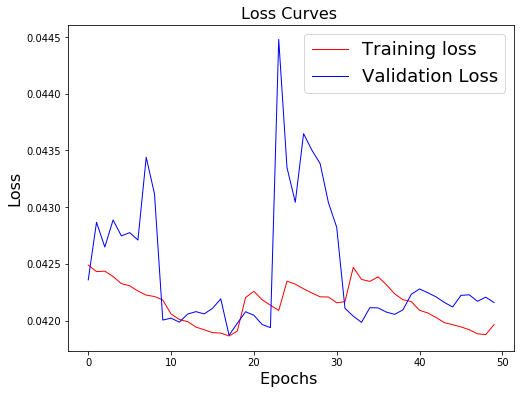

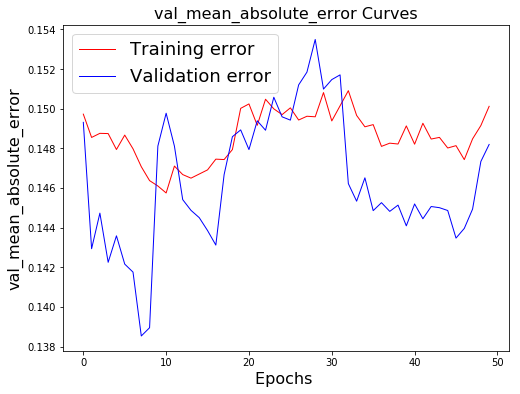

In [51]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history_previous)
list_model_acc_value

[0.0, 0.0]

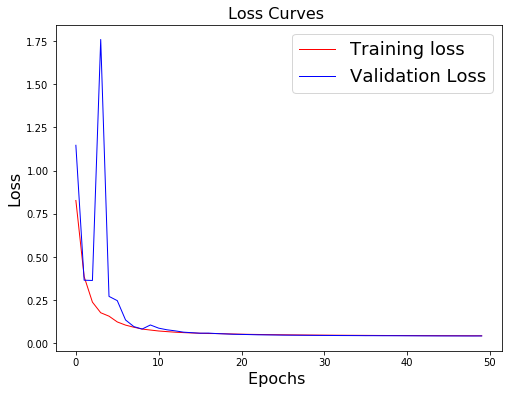

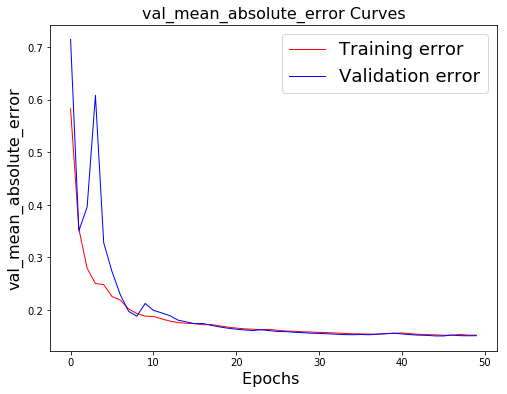

In [8]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

It can be shown that CNN learns quickly but does not learn anymore after 2 epochs.

It is suspected that cost function does not decrease anymore after 2 epochs.

# <font color=blus>4. Switch to classification problem</font>
    Targets, that are real values, are switched to integer, leading to a classification pb.
    For doing that, y_train_encoded and y_test_encoded are transformed as array of integers, 
    ranging from 0 to 10, mean, 11 classes.

In [291]:
import p9_util

nb_classes, y_train_label_encoded = p9_util.y_reg_2_label(y_train_encoded)
_, y_test_label_encoded = p9_util.y_reg_2_label(y_test_encoded)
print("\nNumber of classes issued from one hot encoding= {}".format(nb_classes))


Number of classes issued from one hot encoding= 11


/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can

#### Data normalization

In [312]:
import p9_util

print(X_train_encoded.min(),X_test_encoded.max())
print(X_test_encoded.min(),X_test_encoded.max())
X_train_encoded, X_test_encoded = p9_util.data_scale(X_train_encoded, X_test_encoded)
print()
print(X_train_encoded.min(),X_test_encoded.max())
print(X_test_encoded.min(),X_test_encoded.max())


0.0 1.007735400320794
-7.809510421791658e-06 1.007735400320794

0.0 1.0077354003207941
-7.809510421791658e-06 1.0077354003207941


## <font color=blus>4.1. Classification with CNN using Keras</font>

    Same CNN structure used in regression is also used in classification.
    Convolutional layers are built with strides >0.
    This is equivalent to process Bag Of Words with n-gram.


In [313]:
import p9_util

model = p9_util.keras_cnn_build(max_length, nb_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 25, 64)            384       
_________________________________________________________________
batch_normalization_36 (Batc (None, 25, 64)            256       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 7, 64)             20544     
_________________________________________________________________
batch_normalization_37 (Batc (None, 7, 64)             256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 2, 64)             20544     
_________________________________________________________________
batch_normalization_38 (Batc (None, 2, 64)             256       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1, 128)            57472     
__________

In [314]:
X_train_reshape = X_train_encoded.reshape(-1, max_length,1)
X_test_reshape = X_test_encoded.reshape(-1, max_length,1)
print(X_train_reshape.shape)
print(X_test_reshape.shape)
print()
print(y_train_label_encoded.shape)
print(y_test_label_encoded.shape)


(361241, 100, 1)
(177863, 100, 1)

(361241, 11)
(177863, 11)


In [316]:
batch_size = X_train_reshape.shape[0]//10

history = model.fit(X_train_reshape, y_train_label_encoded, batch_size=batch_size, epochs=30, 
                    verbose=1, validation_data=(X_test_reshape,y_test_label_encoded))

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 26s 72us/step - loss: 1.7511 - acc: 0.5822 - val_loss: 2.2032 - val_acc: 0.2299
Epoch 2/30
361241/361241 [==============================] - 25s 70us/step - loss: 1.3087 - acc: 0.6910 - val_loss: 1.5405 - val_acc: 0.6684
Epoch 3/30
361241/361241 [==============================] - 25s 68us/step - loss: 1.2158 - acc: 0.6990 - val_loss: 1.3864 - val_acc: 0.6653
Epoch 4/30
361241/361241 [==============================] - 24s 66us/step - loss: 1.1843 - acc: 0.6994 - val_loss: 1.2803 - val_acc: 0.6826
Epoch 5/30
361241/361241 [==============================] - 30s 82us/step - loss: 1.1696 - acc: 0.6995 - val_loss: 1.2374 - val_acc: 0.6912
Epoch 6/30
361241/361241 [==============================] - 26s 73us/step - loss: 1.1619 - acc: 0.7000 - val_loss: 1.2269 - val_acc: 0.6944
Epoch 7/30
361241/361241 [==============================] - 26s 71us/step - loss: 1.1584 - acc: 0.7002 - val

In [324]:
import p9_util
metric = 'acc'
metric_val = 'val_acc'
history, history_save = p9_util.remove_history_index(history, metric, metric_val)

[0.0, 0.0]

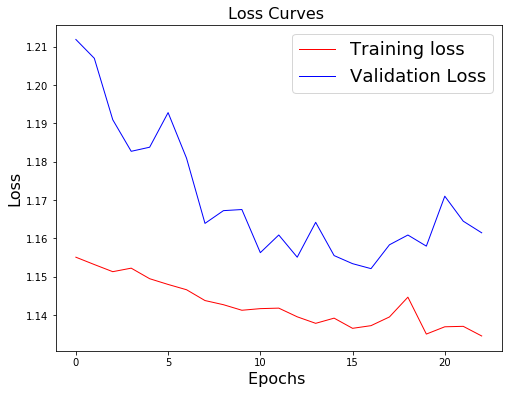

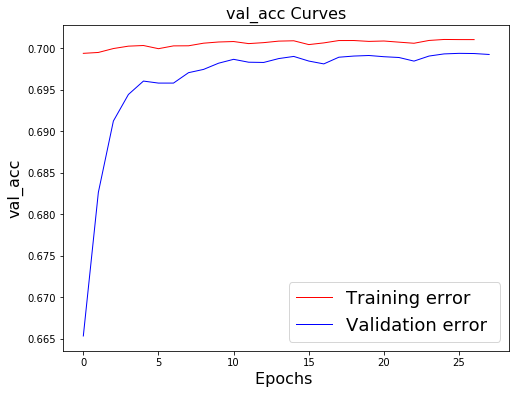

In [325]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

## <font color=blus>4.2. Classification with RNN using Keras</font>

#### A RNN estimator is built with GRU cells.

In [327]:
import p9_util

celltype = keras.layers.GRU
model = p9_util.keras_rnn_build(celltype, cell_units, max_length, isWordEmbedding=False\
                   , nbClasses=nb_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_58 (GRU)                 (None, 1, 1)              306       
_________________________________________________________________
gru_59 (GRU)                 (None, 1)                 9         
_________________________________________________________________
dense_46 (Dense)             (None, 11)                22        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None


#### Reshape arrays for time series

    Arrays are shapes as [obervations, features].

    They are reshaped in order to feed RNN model with one observation to each step.
    
    Then reshaped will lead to [observations, 1, features]



In [329]:
import numpy as np

X_train_reshape = np.reshape(X_train_encoded, (X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_reshape = np.reshape(X_test_encoded, (X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))
print(X_train_reshape.shape)
print(X_test_reshape.shape)

(361241, 1, 100)
(177863, 1, 100)


In [330]:
batch_size = X_train_reshape_threshold.shape[0]//10
history = model.fit(X_train_reshape, y_train_label_encoded, batch_size=batch_size, epochs=30, 
                    verbose=1, validation_data=(X_test_reshape, y_test90ghsTAY#nb@A_label_encoded))

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 6s 16us/step - loss: 2.3872 - acc: 0.5551 - val_loss: 2.3650 - val_acc: 0.6994
Epoch 2/30
361241/361241 [==============================] - 1s 3us/step - loss: 2.3407 - acc: 0.7011 - val_loss: 2.3090 - val_acc: 0.6995
Epoch 3/30
361241/361241 [==============================] - 1s 3us/step - loss: 2.2825 - acc: 0.7011 - val_loss: 2.2498 - val_acc: 0.6995
Epoch 4/30
361241/361241 [==============================] - 1s 3us/step - loss: 2.2235 - acc: 0.7011 - val_loss: 2.1915 - val_acc: 0.6995
Epoch 5/30
361241/361241 [==============================] - 1s 3us/step - loss: 2.1657 - acc: 0.7011 - val_loss: 2.1350 - val_acc: 0.6995
Epoch 6/30
361241/361241 [==============================] - 1s 3us/step - loss: 2.1100 - acc: 0.7011 - val_loss: 2.0805 - val_acc: 0.6995
Epoch 7/30
361241/361241 [==============================] - 1s 3us/step - loss: 2.0563 - acc: 0.7011 - val_loss: 2.0281

In [334]:
history.history = history_save.copy()

[0.0, 0.0]

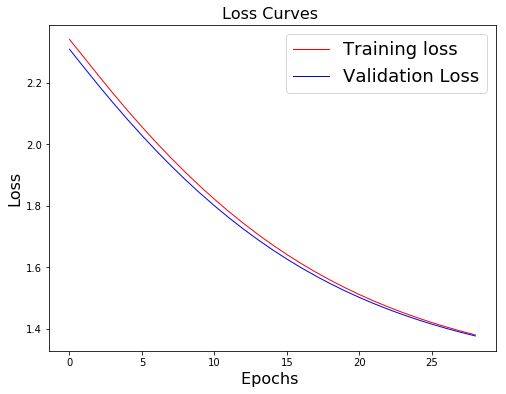

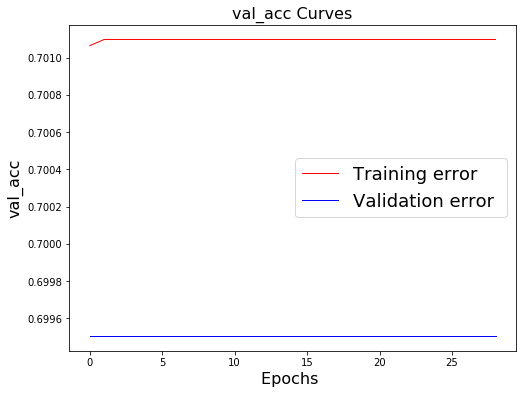

In [335]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

    It is shown that whatever the model used, a limit is reached in term of performance.
    Regression is limited to value 0.14.
    Classification can't reach more then 70% accuacy.
    
    Both results have same order, whatever CNN or RNN estimators used.
    
    With BOW digitalization, RNN structure does not exploit information hidden in sequential structure, 
    ihnerent to texts.

In [22]:
import p9_util

model = p9_util.build_cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 7, 32)             256       
_________________________________________________________________
batch_normalization_34 (Batc (None, 7, 32)             128       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 2, 32)             7200      
_________________________________________________________________
batch_normalization_35 (Batc (None, 2, 32)             128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1, 32)             7200      
_________________________________________________________________
batch_normalization_36 (Batc (None, 1, 32)             128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1, 32)             9248      
__________

In [26]:
import keras
import numpy as np



X_train_reshape = X_train_encoded.reshape(-1, max_length,1)
X_test_reshape = X_test_encoded.reshape(-1, max_length,1)
print(X_train_reshape.shape)
print(X_test_reshape.shape)
print()
print(y_train_label_encoded.shape)
print(y_test_label_encoded.shape)


(273358, 37, 1)
(134465, 37, 1)

(273358, 11)
(134465, 11)


In [27]:
batch_size = X_train_reshape.shape[0]//10

history = model.fit(X_train_reshape, y_train_label_encoded, batch_size=batch_size, epochs=30, 
                    verbose=1, validation_data=(X_test_reshape,y_test_label_encoded))

Train on 273358 samples, validate on 134465 samples
Epoch 1/30
273358/273358 [==============================] - 5s 18us/step - loss: 1.1333 - acc: 0.7098 - val_loss: 1.1936 - val_acc: 0.7026
Epoch 2/30
273358/273358 [==============================] - 3s 10us/step - loss: 1.1617 - acc: 0.7059 - val_loss: 1.1832 - val_acc: 0.7047
Epoch 3/30
273358/273358 [==============================] - 3s 11us/step - loss: 1.1511 - acc: 0.7085 - val_loss: 1.2639 - val_acc: 0.7084
Epoch 4/30
273358/273358 [==============================] - 3s 10us/step - loss: 1.1445 - acc: 0.7098 - val_loss: 1.2754 - val_acc: 0.6998
Epoch 5/30
273358/273358 [==============================] - 3s 11us/step - loss: 1.1442 - acc: 0.7094 - val_loss: 1.3114 - val_acc: 0.6750
Epoch 6/30
273358/273358 [==============================] - 3s 11us/step - loss: 1.1410 - acc: 0.7095 - val_loss: 1.2214 - val_acc: 0.6963
Epoch 7/30
273358/273358 [==============================] - 3s 11us/step - loss: 1.1372 - acc: 0.7098 - val_loss: 

[0.0, 0.0]

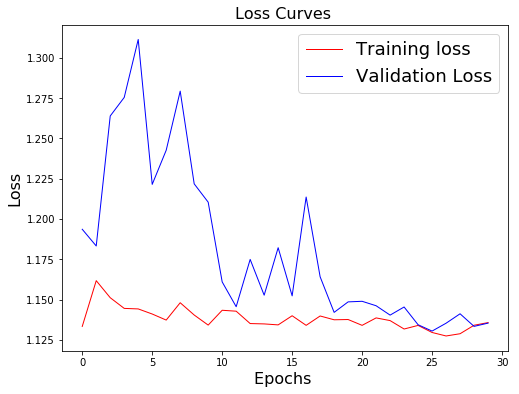

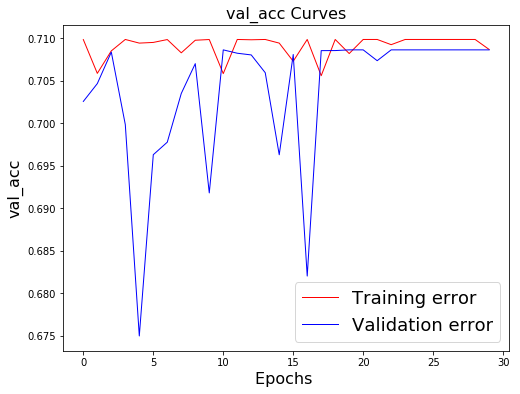

In [28]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

## <font color=blus>4.2. Using GRU cells</font>

    RNN network is used with word embeddings.

In [10]:
cell_units = 1

print("\nInput length= {}".format(max_length))
print("Vocabulary size= {}".format(vocab_size))
print("Batch size= {}".format(batch_size))
print("Embeddings dimension= {}".format(embedding_dim))
print("Number of units per RNN cell= {}".format(cell_units))



Input length= 100
Vocabulary size= 128062
Batch size= 36124
Embeddings dimension= 100
Number of units per RNN cell= 1


In [11]:
X_test_encoded = X_test_encoded[:600]
y_test_label_encoded = y_test_label_encoded[:600]
X_test_encoded.shape,y_test_label_encoded.shape

((600, 100), (600, 11))

In [12]:
#import tensorflow as tf
import keras

model =  keras.models.Sequential()

model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
#model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.GRU(cell_units,return_sequences=True))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.GRU(cell_units,return_sequences=False))
#model.add(keras.layers.Dropout(0.2))

if False :
    model.add(keras.layers.GRU(cell_units))
    #model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(nb_classes,activation='softmax'))

sgd = keras.optimizers.SGD(lr=1.e-3, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.


W0710 20:27:11.766942 139636807825216 deprecation.py:323] From /home/bangui/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0710 20:27:12.043812 139636807825216 deprecation.py:506] From /home/bangui/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          12806200  
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 1)            306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 1)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 9         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                22        
Total params: 12,806,537
Trainable params: 12,806,537
Non-trainable params: 0
________________________________________________________________

In [ ]:
history = model.fit(X_train_encoded, y_train_label_encoded, batch_size =batch_size, nb_epoch = 5
                    ,validation_data=(X_test_encoded,y_test_label_encoded),  verbose = 1)

Instructions for updating:
Use tf.cast instead.


/home/bangui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0710 20:27:17.187641 139636807825216 deprecation.py:323] From /home/bangui/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 361241 samples, validate on 600 samples
Epoch 1/5
252868/361241 [===================>..........] - ETA: 12s - loss: 2.3913 - acc: 0.4341

[0.0, 0.0]

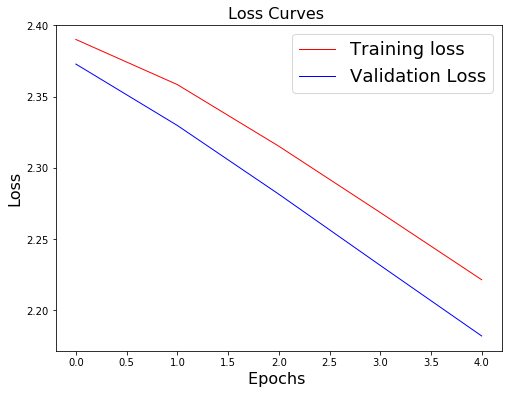

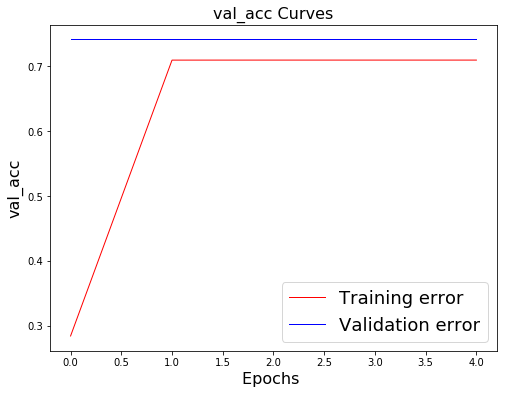

In [81]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

## <font color=blus>4.3. Using GRU cells on threshold</font>

    RNN network is used with no embeddings.

#### Dataset is filtered based on threshold value applied to target values

In [304]:
import p9_util

threshold = None # When None, no function returns identity.
direction = -1 # == operator when direction value is 0

X_train_threshold,  y_train_encoded_threshold = p9_util.dataset_target_filter_threshold(threshold, direction, X_train_encoded, y_train_encoded)
print(X_train_threshold.shape, y_train_encoded_threshold.shape)

X_test_threshold,  y_test_encoded_threshold = p9_util.dataset_target_filter_threshold(threshold, direction, X_test_encoded, y_test_encoded)
print(X_test_threshold.shape, y_test_encoded_threshold.shape)


(361241, 100) (361241,)
(177863, 100) (177863,)


#### Dataset normalization in range from `[0.0 , 1.0]`

In [305]:
import p9_util


print(X_train_threshold.min(),X_train_threshold.max())
print(X_test_threshold.min(),X_test_threshold.max())


X_train_threshold, X_test_threshold = p9_util.data_scale(X_train_threshold, X_test_threshold)

print()
print(X_train_threshold.min(),X_train_threshold.max())
print(X_test_threshold.min(),X_test_threshold.max())


0 128061
0 128061

0.0 1.0
-7.809510421791658e-06 1.007735400320794


In [307]:
cell_units = 1

print("\nInput length= {}".format(max_length))
print("Vocabulary size= {}".format(vocab_size))
print("Batch size= {}".format(batch_size))
print("Embeddings dimension= {}".format(embedding_dim))
print("Number of units per RNN cell= {}".format(cell_units))



Input length= 100
Vocabulary size= 128062
Batch size= 25313
Embeddings dimension= 100
Number of units per RNN cell= 1


In [308]:
import p9_util

celltype = keras.layers.GRU
model = p9_util.keras_rnn_build(celltype, cell_units, max_length, isWordEmbedding=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_56 (GRU)                 (None, 1, 1)              306       
_________________________________________________________________
gru_57 (GRU)                 (None, 1)                 9         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 2         
Total params: 317
Trainable params: 317
Non-trainable params: 0
_________________________________________________________________
None


#### Reshape arrays for time series

    Arrays are shapes as [obervations, features].

    They are reshaped in order to feed RNN model with one observation to each step.
    
    Then reshaped will lead to [observations, 1, features]



In [288]:
X_train_threshold_reshape = np.reshape(X_train_threshold, (X_train_threshold.shape[0], 1, X_train_threshold.shape[1]))
X_test_threshold_reshape = np.reshape(X_test_threshold, (X_test_threshold.shape[0], 1, X_test_threshold.shape[1]))
print(X_train_threshold_reshape.shape)
print(X_test_threshold_reshape.shape)

(361241, 1, 100)
(177863, 1, 100)


In [289]:
batch_size = X_train_reshape_threshold.shape[0]//10
history = model.fit(X_train_threshold_reshape, y_train_encoded_threshold, batch_size=batch_size, epochs=30, 
                    verbose=1, validation_data=(X_test_threshold_reshape,y_test_encoded_threshold))

Train on 361241 samples, validate on 177863 samples
Epoch 1/30
361241/361241 [==============================] - 7s 21us/step - loss: 0.0487 - mean_absolute_error: 0.1106 - val_loss: 0.0461 - val_mean_absolute_error: 0.1131
Epoch 2/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.0442 - mean_absolute_error: 0.1179 - val_loss: 0.0421 - val_mean_absolute_error: 0.1238
Epoch 3/30
361241/361241 [==============================] - 1s 2us/step - loss: 0.0412 - mean_absolute_error: 0.1279 - val_loss: 0.0402 - val_mean_absolute_error: 0.1325
Epoch 4/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.0399 - mean_absolute_error: 0.1352 - val_loss: 0.0395 - val_mean_absolute_error: 0.1381
Epoch 5/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.0395 - mean_absolute_error: 0.1397 - val_loss: 0.0393 - val_mean_absolute_error: 0.1414
Epoch 6/30
361241/361241 [==============================] - 1s 3us/step - loss: 0.0394 - mean_abs

[0.0, 0.0]

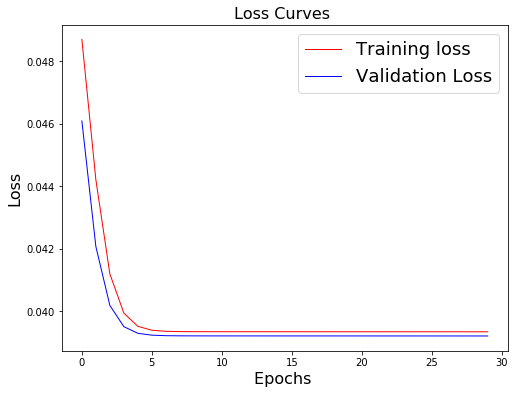

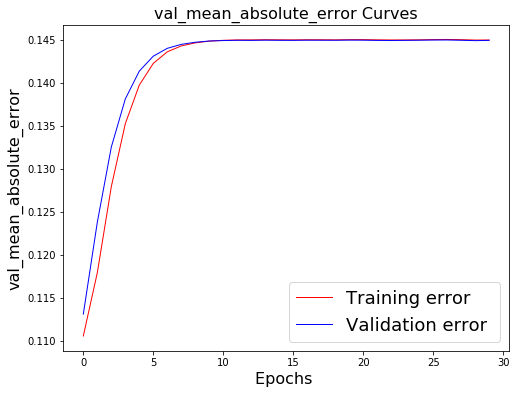

In [290]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

    The whole dataset without any filter using GRU cells

[0.0, 0.0]

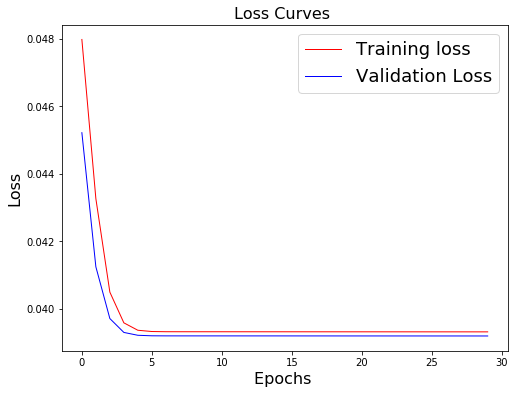

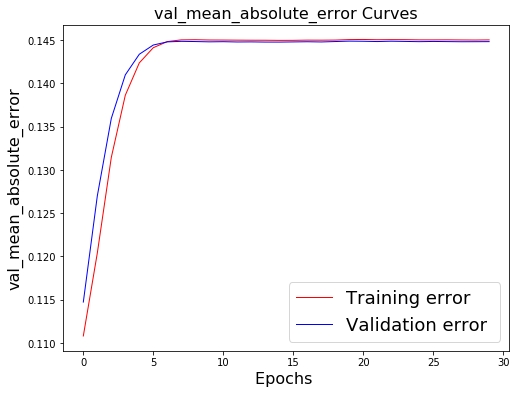

In [264]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

    GRU cell model with condition : target values < 1.e-6

[0.0, 0.0]

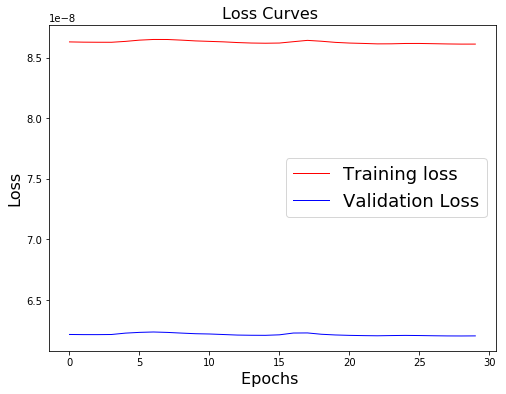

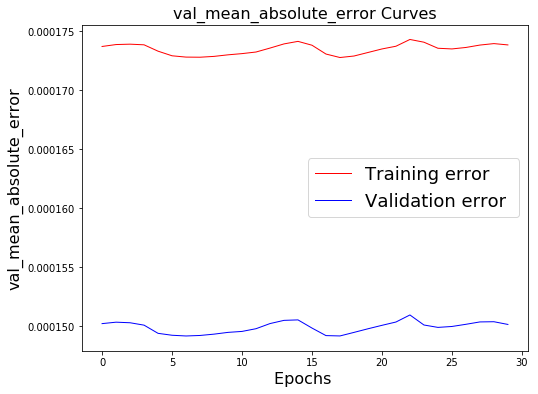

In [254]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

    As expected on graph above, network does not learn anything

    GRU cell model with condition : target values == 0.0

[0.0, 0.0]

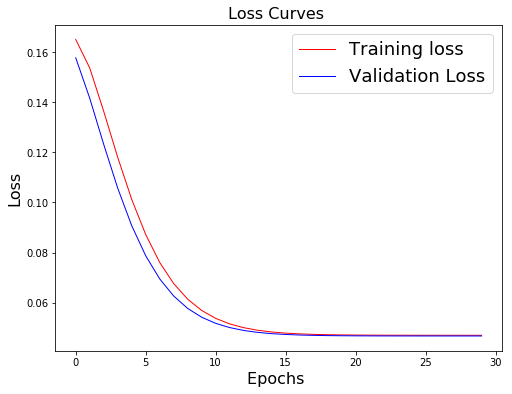

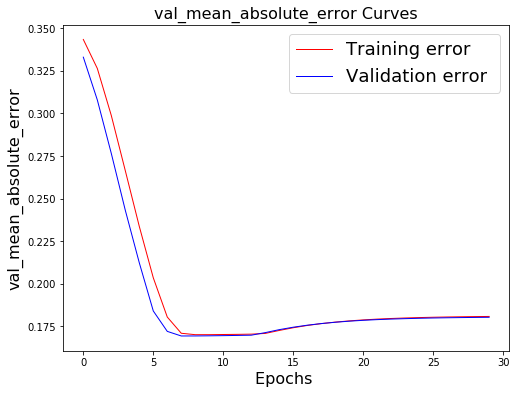

In [242]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value

[0.0, 0.0]

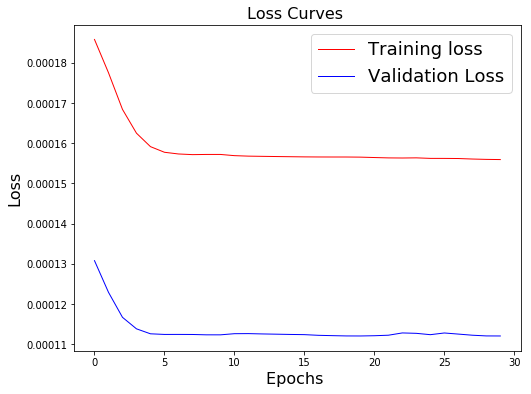

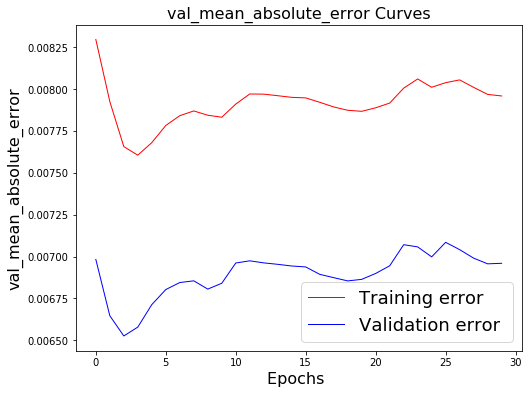

In [223]:
import p7_util

list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history)
list_model_acc_value